# QF 627 Take Home Assignment
## Group 1｜ 23rd November 2024
##### Lee Cheng Da - ID: 01520832
##### Prathmesh Sanjay Desai - ID: 01498430
##### Yash AshishKumar Joshi - ID: 01495321
##### Rohen s/o veera kumaran - ID: 01370722

#### Dependencies

In [218]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

import datetime as dt
import warnings
warnings.filterwarnings("ignore")

In [219]:
import time
import re
from itertools import combinations
import itertools
import plotly.express as px
import pandas_datareader.data as web
from pandas_datareader import data as pdr


# Set print options.

np.set_printoptions(precision = 3)
plt.style.use("ggplot") # Grammar of Graphics Theme
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["legend.fontsize"] = 14

from tabulate import tabulate

%matplotlib inline

In [220]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# ENSEMBLE

## Bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, ward

from statsmodels.tsa.stattools import coint

from itertools import cycle

# for data split
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import PolynomialFeatures

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf

from itertools import cycle

## 👉 <a id = "top">Table of Content</a> 👈 

# [PART1 STRATEGY](#part1)
### [1.1 MOMENTUM STRATEGY](#p1)
##### [1.1.1 Simple Moving Average](#p2)
##### [1.1.2 Exponential Moving Average](#p3)
##### [1.1.3 Chande Momentum Oscillator ](#p4)
##### [1.1.4 VIX ](#p5)
### [1.2 Mean Reversion](#p6)
#### [1.2.1 Bollinger band Strategy ](#p7)
### [1.3 Combined Strategy](#8)
#### [1.3.1 SMA and CMO Strategy ](#p9)
#### [1.3.1 SMA and CMO and VIX Strategy ](#p10)
### [1.4 Machine Learning](#p11)

# [PART2 BACKTESTING](#p12)
##### [2.1 Simple Moving Average backtest](#p13)
##### [2.2 Exponential Moving Average backtest](#p14)
##### [2.3 Chande Momentum Oscillator backtest](#p15)
##### [2.4 VIX backtest](#p16)
##### [2.5 Bollinger band backtest](#p17)
##### [2.6 SMA and CMO backtest](#p18)
##### [2.7 SMA and CMO and VIX Strategy ](#p19)
##### [2.8 Machine learning backtest](#p20)
# [PART3 EXECUTIVE SUMMARY](#p21)
# [PART4 SELF CRITIQUE AND DISCUSSION](#p22)
##### [4.1 SMA and CMO and VIX reflection](#p23)
##### [4.2  VIX reflection](#p24)
##### [4.3 ARIMA-X VIX reflection](#p25)
# [PART5 Contribution Statement](#p26)

# <a id = "part1"> </a> <font color = "green"> PART1 BUILD STRATEGY</font>  [back to table of contents](#top)

In [221]:
# Define function to calculate cum_return
def cal_strat_return(stock1):
    stock = stock1.copy()
    
    stock["daily_return"] = np.log(stock['Adj Close'] / stock['Adj Close'].shift(1))
    
    stock["str_return"] = stock["position"].shift(1) * stock["daily_return"]
    stock["strat_return"] = stock['str_return'].cumsum().apply(np.exp)
    return stock

In [222]:
spy_adj_close = yf.download(
    'SPY',
    start = '2005-11-01',
    end = '2024-10-31'
)['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [223]:
def long_and_hold_backtest(spy_df, initial_capital, signal_column, price_column):
    
    # Initialize cash and holdings
    cash = initial_capital
    shares = 0
    portfolio_values = []

    # Simulate trading
    for date, row in spy_df.iterrows():
        signal = row[signal_column]
        price = row[price_column]
        
        # Buy signal
        if signal == 2 and shares == 0:
            shares = cash / price
            cash = 0
        
        # Sell signal
        elif signal == -2 and shares > 0:
            cash = shares * price
            shares = 0
        
        # Calculate portfolio value
        portfolio_value = cash + shares * price
        portfolio_values.append(portfolio_value)
    spy_df['Portfolio Value'] = portfolio_values

    # Calculate cumulative return
    spy_df['Cumulative Return'] = (spy_df['Portfolio Value'] / initial_capital) - 1

    # Calculate daily returns
    spy_df['Daily Return'] = spy_df['Portfolio Value'].pct_change().fillna(0)

    # Sharpe Ratio
    avg_daily_return = spy_df['Daily Return'].mean()
    std_daily_return = spy_df['Daily Return'].std()
    sharpe_ratio = (avg_daily_return ) / std_daily_return * np.sqrt(252)

    # CAGR (Compound Annual Growth Rate)
    n_years = (spy_df.index[-1] - spy_df.index[0]).days / 365
    final_portfolio_value = portfolio_values[-1]
    cagr = (final_portfolio_value / initial_capital) ** (1 / n_years) - 1

    # Maximum Drawdown (MDD)
    rolling_max = spy_df['Portfolio Value'].cummax()
    drawdown = (spy_df['Portfolio Value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Total return
    total_return = ((final_portfolio_value - initial_capital) / initial_capital) * 100

    print(f"\nFinal Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"CAGR: {cagr:.2%}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    spy_df['SPY Cumulative Returns'] = (spy_df[price_column] / spy_df[price_column].iloc[0])

    # Plot Portfolio Value and SPY Cumulative Returns
    plt.figure(figsize=(12, 6))
    plt.plot(spy_df.index, spy_df['Portfolio Value'], label='Portfolio Value', color='blue')
    plt.plot(spy_df.index, spy_df['SPY Cumulative Returns'] * initial_capital, label='SPY Benchmark', color='orange')
    plt.title('Portfolio Value vs SPY Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.show()

    



In [224]:
def long_short_sell_backtest(spy_df, initial_capital, signal_column, price_column):

    # Initialize variables
    portfolio_value = initial_capital
    position = 0  # 1 for long, -1 for short, 0 for no position
    portfolio_values = []
    prev_price = None

    # Simulate trading
    for date, row in spy_df.iterrows():
        signal = row[signal_column]
        price = row[price_column]
        
        # Calculate daily return and update portfolio value
        if prev_price is not None:
            daily_return = (price - prev_price) / prev_price
            # Adjust return based on position
            daily_return *= position
            # Update portfolio value
            portfolio_value *= (1 + daily_return)
        
        # Determine position based on signal
        if signal == 2:
            if position != 1:
                # Close the previous short position (if any)
                if position == -1:
                    portfolio_value *= (1 - (prev_price - price) / prev_price)
                position = 1
        elif signal == -2:
            if position != -1:
                # Close the previous long position (if any)
                if position == 1:
                    portfolio_value *= (1 + (prev_price - price) / prev_price)
                position = -1

        portfolio_values.append(portfolio_value)
        prev_price = price

    # Add portfolio values to DataFrame
    spy_df['Portfolio Value'] = portfolio_values

    # Final portfolio value and return
    final_portfolio_value = portfolio_values[-1]
    total_return = ((final_portfolio_value - initial_capital) / initial_capital) * 100

    # Calculate cumulative return
    spy_df['Cumulative Return'] = (spy_df['Portfolio Value'] / initial_capital) - 1

    # Calculate daily returns
    spy_df['Daily Return'] = spy_df['Portfolio Value'].pct_change().fillna(0)

    # Sharpe Ratio
    avg_daily_return = spy_df['Daily Return'].mean()
    std_daily_return = spy_df['Daily Return'].std()
    sharpe_ratio = (avg_daily_return ) / std_daily_return * np.sqrt(252)

    # CAGR (Compound Annual Growth Rate)
    n_years = (spy_df.index[-1] - spy_df.index[0]).days / 365
    final_portfolio_value = portfolio_values[-1]
    cagr = (final_portfolio_value / initial_capital) ** (1 / n_years) - 1

    # Maximum Drawdown (MDD)
    rolling_max = spy_df['Portfolio Value'].cummax()
    drawdown = (spy_df['Portfolio Value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    print(f"\nFinal Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"CAGR: {cagr:.2%}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    spy_df['SPY Cumulative Returns'] = (spy_df[price_column] / spy_df[price_column].iloc[0])
    # Plot Portfolio Value and SPY Cumulative Returns
    plt.figure(figsize=(12, 6))
    plt.plot(spy_df.index, spy_df['Portfolio Value'], label='Portfolio Value', color='blue')
    plt.plot(spy_df.index, spy_df['SPY Cumulative Returns'] * initial_capital, label='SPY Benchmark', color='orange')
    plt.title('Portfolio Value vs SPY Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.show()



In [225]:
def ml_backtest(spy_df, initial_capital, signal_column, log_return_column):
    
    # Initialize variables
    portfolio_value = initial_capital
    position = 0  # 1 for long, -1 for short, 0 for no position
    portfolio_values = []
    cumulative_log_return = 0  # Cumulative log return

    # Simulate trading
    for date, row in spy_df.iterrows():
        signal = row[signal_column]
        log_return = row[log_return_column]

        # Update cumulative log return and portfolio value
        if position != 0:
            cumulative_log_return += log_return * position
            portfolio_value = initial_capital * np.exp(cumulative_log_return)

        # Determine position based on signal
        if signal == 2:  # Go long
            if position != 1:
                position = 1
        elif signal == -2:  # Go short
            if position != -1:
                position = -1

        portfolio_values.append(portfolio_value)

    # Add portfolio values to DataFrame
    spy_df['Portfolio Value'] = portfolio_values

    # Final portfolio value and return
    final_portfolio_value = portfolio_values[-1]
    total_return = ((final_portfolio_value - initial_capital) / initial_capital) * 100

    # Calculate cumulative return
    spy_df['Cumulative Return'] = (spy_df['Portfolio Value'] / initial_capital) - 1

    # Calculate daily returns
    spy_df['Daily Return'] = spy_df['Portfolio Value'].pct_change().fillna(0)

    # Sharpe Ratio
    avg_daily_return = spy_df['Daily Return'].mean()
    std_daily_return = spy_df['Daily Return'].std()
    sharpe_ratio = avg_daily_return / std_daily_return * np.sqrt(252)

    # CAGR (Compound Annual Growth Rate)
    n_years = (spy_df.index[-1] - spy_df.index[0]).days / 365.25
    cagr = (final_portfolio_value / initial_capital) ** (1 / n_years) - 1

    # Maximum Drawdown (MDD)
    rolling_max = spy_df['Portfolio Value'].cummax()
    drawdown = (spy_df['Portfolio Value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Print performance metrics
    print(f"\nFinal Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"CAGR: {cagr:.2%}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")

    # Benchmark: SPY Cumulative Returns
    spy_df['SPY Cumulative Returns'] = np.exp(spy_df[log_return_column].cumsum())

    # Plot Portfolio Value and SPY Cumulative Returns
    plt.figure(figsize=(12, 6))
    plt.plot(spy_df.index, spy_df['Portfolio Value'], label='Portfolio Value', color='blue')
    plt.plot(spy_df.index, spy_df['SPY Cumulative Returns'] * initial_capital, label='SPY Benchmark', color='orange')
    plt.title('Portfolio Value vs SPY Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.show()


In [226]:
spy_adj_close
spy_df = spy_adj_close.to_frame(name='Adj Close')
spy_df = pd.DataFrame(spy_df)

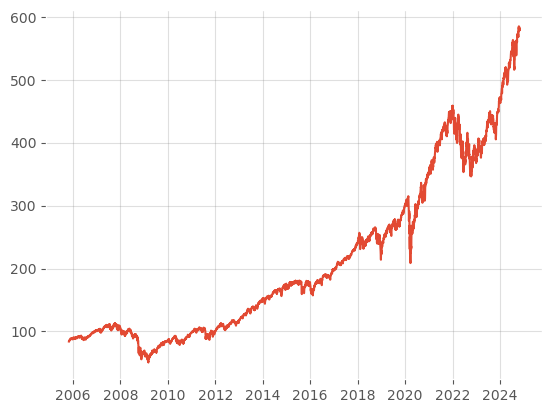

In [227]:
plt.plot(spy_df)

## <a id="p1">1.1</a> <font color="green">Momentum Strategy</font>  [back to table of contents](#top)


### <a id = "p2">1.1.1 </a> <font color = "green"> Simple Moving Average¶ </font>  [back to table of contents](#top) / [Backtesting result](#p13)

In [228]:
def set_SMA_position(stock, short, long):
    stock = stock.copy()
    
    short = short
    long = long

    stock["long_SMA"] =\
    stock["Adj Close"].rolling(window = long,min_periods = 1).mean()
    
    stock["short_SMA"] =\
    stock["Adj Close"].rolling(short,min_periods = 1).mean()

    stock["SMA_position"] = np.where(
                            stock["short_SMA"]
                            <=
                            stock["long_SMA"], 
                            -1, 
                            1)
    stock.dropna(inplace = True)
    return stock["SMA_position"]

In [229]:
def tuning_SMA(stock1, short_periods, long_periods):
    stock = stock1.copy()
    best_result = float('-inf')
    
    best_result = 0
    for short in short_periods:
        for long in long_periods:
            if short < long:
                    stock['position'] = set_SMA_position(stock1, short, long)
                    stock['strat_return'] = cal_strat_return(stock)["strat_return"]
                    if stock['strat_return'].iloc[-1] > best_result:
                        best_result = stock['strat_return'].iloc[-1]
                        parameters = (short, long)
                
    return parameters, best_result 

In [230]:
short = range(5, 155)
long = range(10,156)

tuning_SMA(spy_df,short,long)

((151, 152), 8.464858742730286)

In [231]:
spy_df["long_SMA"] =\
spy_df["Adj Close"].rolling(152,min_periods = 1).mean()
    
spy_df["short_SMA"] =\
spy_df["Adj Close"].rolling(151,min_periods = 1).mean()

spy_df["SMA_position"] = np.where(
    spy_df["short_SMA"]>=spy_df["long_SMA"], 
                            1, -1)
spy_df.dropna(inplace = True)

In [232]:
spy_df['SMA_trading_position'] = spy_df['SMA_position'].diff()
spy_df['SMA_trading_position'][0] = 2


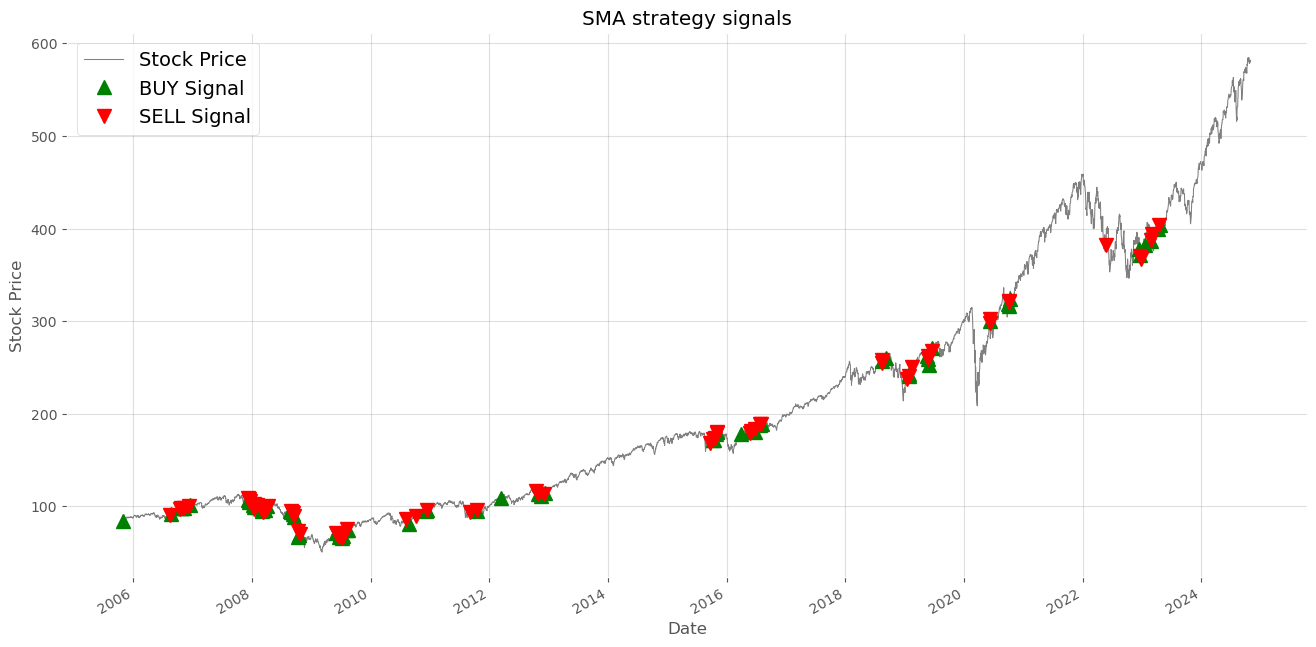

In [233]:
fig = plt.figure(figsize=[16, 8])
sub = fig.add_subplot(111, ylabel="Stock Price")

# Plot stock price
spy_df["Adj Close"].plot(ax=sub, color="grey", linewidth=0.75, label="Stock Price")

#BUY
sub.plot(
    spy_df.loc[spy_df['SMA_trading_position'] == 2.0].index,  # x-axis: Dates
    spy_df.loc[spy_df['SMA_trading_position'] == 2.0, "Adj Close"],  # y-axis: Prices
    "^",  # Marker
    color="green",
    markersize=10,
    label="BUY Signal"
)

#SELL
sub.plot(
    spy_df.loc[spy_df['SMA_trading_position'] == -2.0].index,  # x-axis: Dates
    spy_df.loc[spy_df['SMA_trading_position'] == -2.0, "Adj Close"],  # y-axis: Prices
    "v",  # Marker
    color="red",
    markersize=10,
    label="SELL Signal"
)
plt.title('SMA strategy signals')
sub.legend(loc="best")
plt.show()


### <a id = "p3">1.1.2 </a> <font color = "green"> Exponential Moving Average¶ </font>  [back to table of contents](#top) / [Backtesting result](#p14)

In [234]:
def set_EMA_position(stock, short, long):
    stock = stock.copy()
    
    short = short
    long = long

    stock["long_EMA"] =\
    stock["Adj Close"].ewm(span = long, adjust = False).mean()
    
    stock["short_EMA"] =\
    stock["Adj Close"].ewm(span = short, adjust = False).mean()

    stock["EMA_position"] = np.where(
                            stock["short_EMA"]
                            >=
                            stock["long_EMA"], 
                            1, 
                            -1)
    stock.dropna(inplace = True)
    return stock["EMA_position"]

In [235]:
def tuning_EMA(stock1, short_periods, long_periods):
    stock = stock1.copy()
    best_result = float('-inf')
    
    best_result = 0
    for short in short_periods:
        for long in long_periods:
            if short < long:
                    stock['position'] = set_EMA_position(stock1, short, long)
                    stock['strat_return'] = cal_strat_return(stock)["strat_return"]
                    if stock['strat_return'].iloc[-1] > best_result:
                        best_result = stock['strat_return'].iloc[-1]
                        parameters = (short, long)
                
    return parameters, best_result 

In [236]:
short = range(150,200 )
long = range(230,260)

tuning_EMA(spy_df,short,long)

((191, 259), 9.154069585051591)

In [237]:
spy_df["long_EMA"] =\
spy_df["Adj Close"].ewm(span = 259, adjust = False).mean()
    
spy_df["short_EMA"] =\
spy_df["Adj Close"].ewm(span = 191, adjust = False).mean()

spy_df["EMA_position"] = np.where(
    spy_df["short_EMA"]>=spy_df["long_EMA"], 1, -1)

In [238]:
spy_df['EMA_trading_position'] = spy_df['EMA_position'].diff()
spy_df['EMA_trading_position'][0]=2

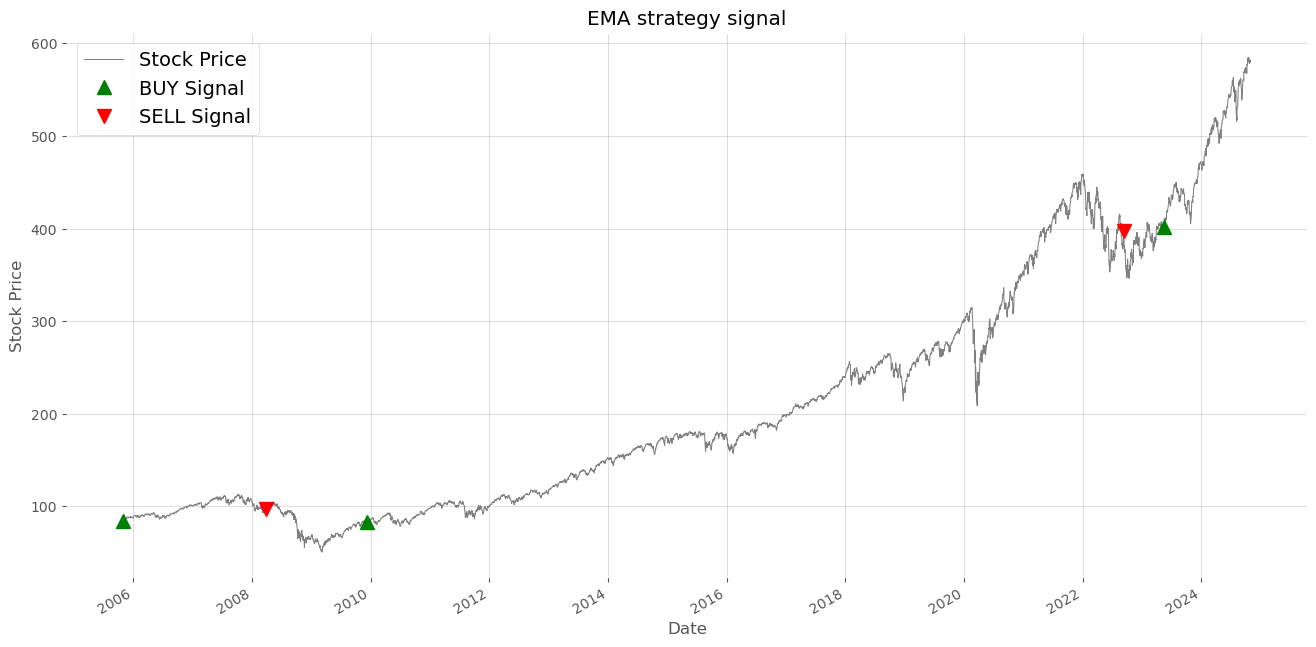

In [239]:
fig = plt.figure(figsize=[16, 8])
sub = fig.add_subplot(111, ylabel="Stock Price")

# Plot stock price
spy_df["Adj Close"].plot(ax=sub, color="grey", linewidth=0.75, label="Stock Price")

#BUY
sub.plot(
    spy_df.loc[spy_df['EMA_trading_position'] == 2.0].index,  # x-axis: Dates
    spy_df.loc[spy_df['EMA_trading_position'] == 2.0, "Adj Close"],  # y-axis: Prices
    "^",  # Marker
    color="green",
    markersize=10,
    label="BUY Signal"
)

#SELL
sub.plot(
    spy_df.loc[spy_df['EMA_trading_position'] == -2.0].index,  # x-axis: Dates
    spy_df.loc[spy_df['EMA_trading_position'] == -2.0, "Adj Close"],  # y-axis: Prices
    "v",  # Marker
    color="red",
    markersize=10,
    label="SELL Signal"
)
plt.title('EMA strategy signal')

sub.legend(loc="best")
plt.show()


### <a id = "p4">1.1.3 </a> <font color = "green"> Chande Momentum Oscillator¶ </font>  [back to table of contents](#top) / [Backtesting result](#p15)

In [240]:
def set_CMO_position(stock, period):
    stock = stock.copy()
  
    stock['Change'] = stock['Adj Close'].diff()
    stock['Gain'] = np.where(stock['Change'] > 0, stock['Change'], 0)
    stock['Loss'] = np.where(stock['Change'] < 0, -stock['Change'], 0)

    stock['sum_gain'] = stock['Gain'].rolling(window=period,min_periods=1).sum()
    stock['sum_loss'] = stock['Loss'].rolling(window=period,min_periods=1).sum()

    stock['cmo'] = ((stock['sum_gain'] - stock['sum_loss']) / (stock['sum_gain'] + stock['sum_loss'])) * 100
    stock['CMO_position']= np.where(
        stock['cmo']<=-10,
        -1,
        1
    )
    stock.dropna(inplace=True)
    return stock['CMO_position']

In [241]:
def tuning_CMO(stock1,period):
    period = period
    stock = stock1.copy()
    best_result = float('-inf')
    
    best_result = 0
    for period in period:
                    stock['position'] = set_CMO_position(stock1, period)
                    stock['strat_return'] = cal_strat_return(stock)["strat_return"]
                    if stock['strat_return'].iloc[-1] > best_result:
                        best_result = stock['strat_return'].iloc[-1]
                        parameters = (period)
                
    return parameters, best_result 

In [242]:
period = range(1, 301)


tuning_CMO(spy_df,period)

(273, 11.010608746604294)

In [243]:
spy_df['Change'] = spy_df['Adj Close'].diff()
spy_df['Gain'] = np.where(spy_df['Change'] > 0, spy_df['Change'], 0)
spy_df['Loss'] = np.where(spy_df['Change'] < 0, -spy_df['Change'], 0)

spy_df['sum_gain'] = spy_df['Gain'].rolling(window=273,min_periods=1).sum()
spy_df['sum_loss'] = spy_df['Loss'].rolling(window=273,min_periods=1).sum()

spy_df['cmo'] = ((spy_df['sum_gain'] - spy_df['sum_loss']) / (spy_df['sum_gain'] + spy_df['sum_loss'])) * 100
spy_df['CMO_position']= np.where(
        spy_df['cmo']<=-10,
        -1,
        1
    )

In [244]:
spy_df['CMO_trading_position'] = spy_df['CMO_position'].diff()
spy_df['CMO_trading_position'][0] = 2

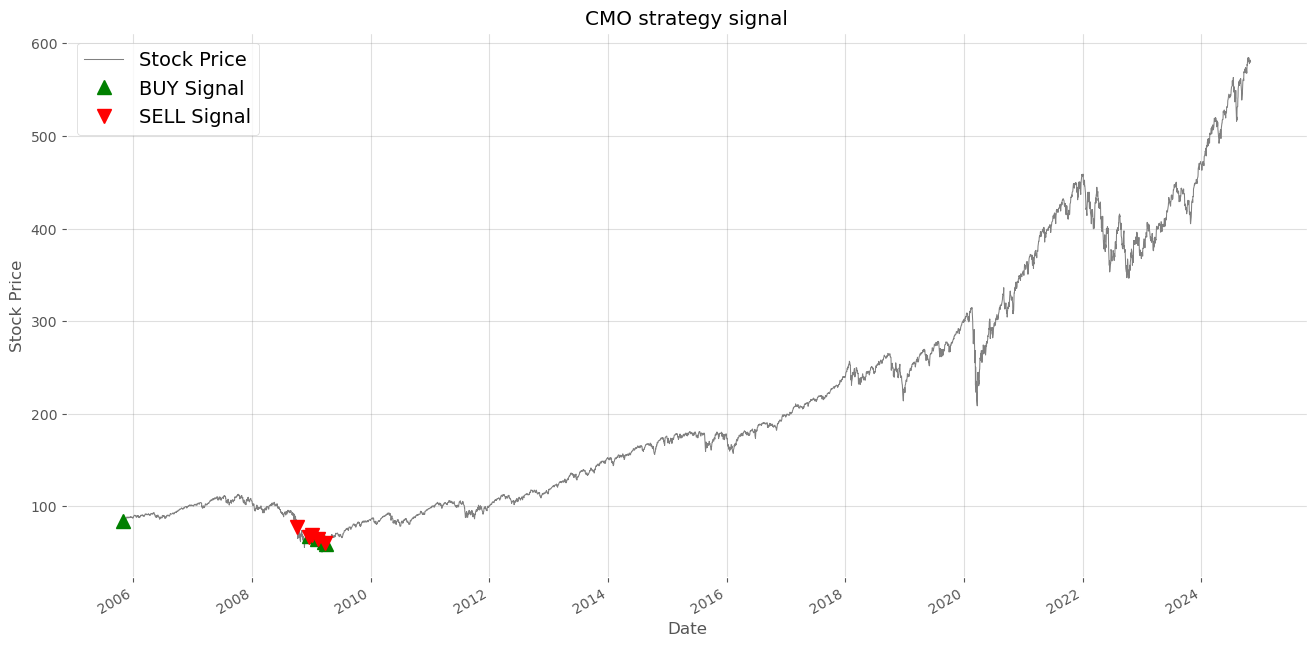

In [245]:
fig = plt.figure(figsize=[16, 8])
sub = fig.add_subplot(111, ylabel="Stock Price")

# Plot stock price
spy_df["Adj Close"].plot(ax=sub, color="grey", linewidth=0.75, label="Stock Price")

#BUY
sub.plot(
    spy_df.loc[spy_df['CMO_trading_position'] == 2.0].index,  # x-axis: Dates
    spy_df.loc[spy_df['CMO_trading_position'] == 2.0, "Adj Close"],  # y-axis: Prices
    "^",  # Marker
    color="green",
    markersize=10,
    label="BUY Signal"
)

#SELL
sub.plot(
    spy_df.loc[spy_df['CMO_trading_position'] == -2.0].index,  # x-axis: Dates
    spy_df.loc[spy_df['CMO_trading_position'] == -2.0, "Adj Close"],  # y-axis: Prices
    "v",  # Marker
    color="red",
    markersize=10,
    label="SELL Signal"
)
plt.title('CMO strategy signal')

sub.legend(loc="best")
plt.show()


### <a id = "p5">1.1.4 </a> <font color = "green"> VIX¶ </font>  [back to table of contents](#top) / [Backtesting result](#16)

In [246]:
spy_df['vix'] = yf.download('^VIX',
                            start = '2005-11-01',
                            end = '2024-10-31'
                            )['Adj Close']

[*********************100%%**********************]  1 of 1 completed


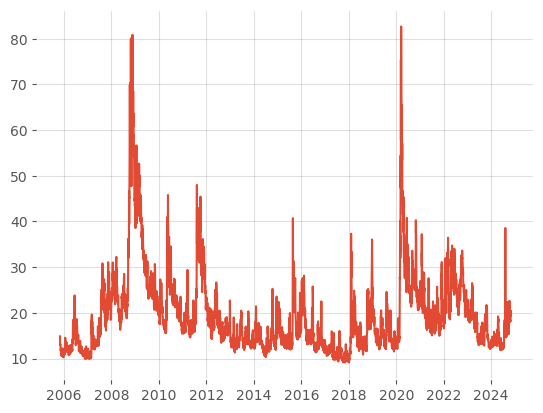

In [247]:
plt.plot(spy_df['vix'])

In [248]:
def set_VIX_position(stock, window):
    stock = stock.copy()
    window = window
    

    stock['vix_sd'] = stock['vix'].rolling(window = window,min_periods = 1).std()
    stock['middle_band'] = stock['vix'].rolling(window=window,min_periods=1).mean()
    stock['upper_band'] = stock['vix_sd']*2.5 + stock['middle_band']
    stock['VIX_position'] = np.where(stock['vix'] > stock['upper_band'],-1,1)

    stock.dropna(inplace=True)
    return stock['VIX_position']

In [249]:
def tuning_VIX(stock1,window):
    window  = window
    stock = stock1.copy()
    best_result = float('-inf')
    
    best_result = 0
    for window in window:
        stock['position'] = set_VIX_position(stock1, window)
        stock['strat_return'] = cal_strat_return(stock)["strat_return"]
        if stock['strat_return'].iloc[-1] > best_result:
                        best_result = stock['strat_return'].iloc[-1]
                        parameters = (window)
                
    return parameters, best_result 

In [250]:
window = range(1,100)


tuning_VIX(spy_df,window)

(90, 14.327342394225882)

In [251]:

spy_df['vix_sd'] = spy_df['vix'].rolling(window = 90,min_periods=1).std()
spy_df['middle_band'] = spy_df['vix'].rolling(window=90,min_periods=1).mean()
spy_df['upper_band'] = spy_df['vix_sd']*2.5 + spy_df['middle_band']
spy_df['VIX_position'] = np.where(spy_df['vix'] > spy_df['upper_band'],-1,1)
spy_df=spy_df.dropna()


In [252]:
spy_df['VIX_trading_position'] = spy_df['VIX_position'].diff()
spy_df['VIX_trading_position'][0] = 2

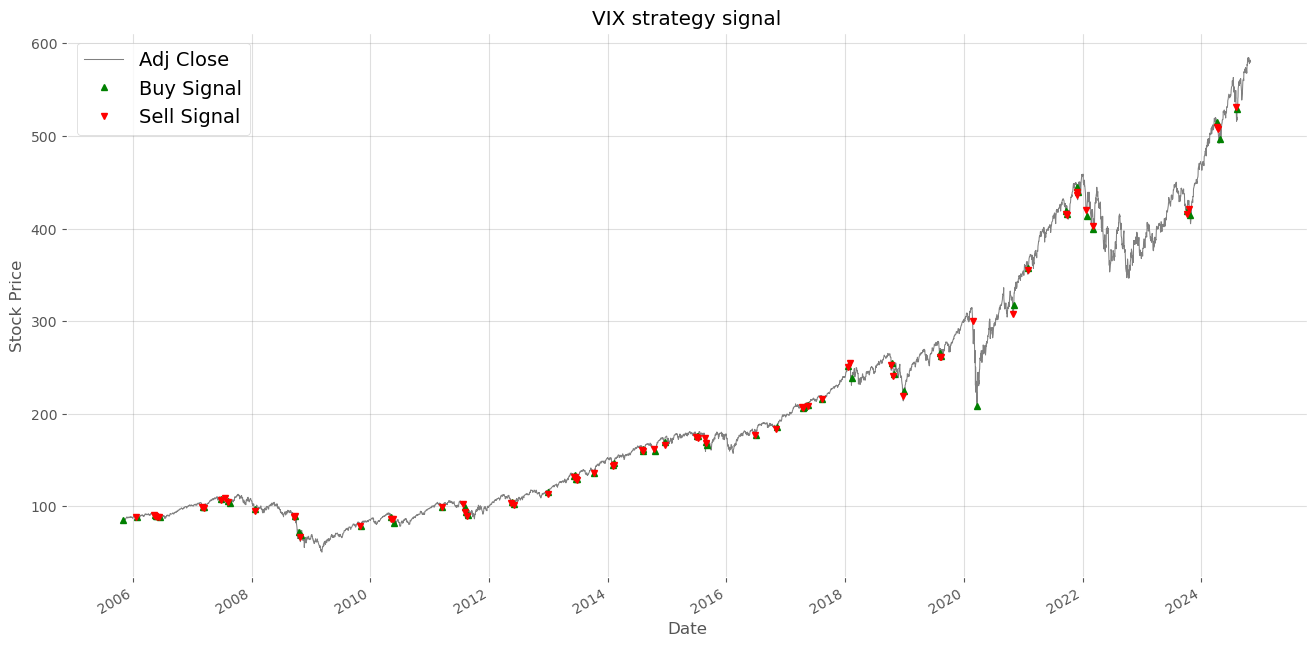

In [253]:
fig = plt.figure(figsize=[16, 8])

sub = fig.add_subplot(111, ylabel="Stock Price")

# Plot the stock prices
spy_df["Adj Close"].plot(ax=sub, color="grey", linewidth=0.75)

# BUY signal
sub.plot(
    spy_df.loc[spy_df['VIX_trading_position'] == 2.0].index,
    spy_df.loc[spy_df['VIX_trading_position'] == 2.0, "Adj Close"],
    "^",
    color="green",
    markersize=5,
    label="Buy Signal",
)

# SELL signal
sub.plot(
    spy_df.loc[spy_df['VIX_trading_position'] == -2.0].index,
    spy_df.loc[spy_df['VIX_trading_position'] == -2.0, "Adj Close"],
    "v",
    color="red",
    markersize=5,
    label="Sell Signal",
)

# Add legend
sub.legend()

# Show the plot
plt.title('VIX strategy signal')
plt.show()


## <a id = "p6">1.2 </a> <font color = "green"> Mean-Reversion Strategy </font>  [back to table of contents](#top)

### <a id = "p7">1.1.1 </a> <font color = "green"> Bollinger band¶ </font>  [back to table of contents](#top) / [Backtesting result](#17)

In [254]:
def set_bollinger_position(stock, window):
    stock = stock.copy()
    
    window = window

    stock["boll_mean"] =\
    stock["Adj Close"].rolling(window = window,min_periods = 1).mean()
    stock['boll_std'] =\
    stock["boll_mean"].std()



    stock["boll_position"] = np.where(
                            stock["Adj Close"]
                            >=
                            stock["boll_mean"]+stock['boll_std']*2, 
                            -1, 
                            1)
    stock.dropna(inplace = True)
    return stock["boll_position"]

In [255]:
def tuning_boll(stock1, window):
    stock = stock1.copy()
    best_result = float('-inf')
    window = window
    best_result = 0
    for window in window:
                    stock['position'] = set_bollinger_position(stock1,window)
                    stock['strat_return'] = cal_strat_return(stock)["strat_return"]
                    if stock['strat_return'].iloc[-1] > best_result:
                        best_result = stock['strat_return'].iloc[-1]
                        parameters = (window)
                
    return parameters, best_result 

In [256]:
window=range(2,30)

tuning_boll(spy_df,window)

(2, 6.834142723712077)

In [257]:
spy_df["boll_mean"] =\
spy_df["Adj Close"].rolling(window =2,min_periods = 1).mean()
spy_df['boll_std'] =\
spy_df["boll_mean"].std()



spy_df["BOLL_position"] = np.where(
                            spy_df["Adj Close"]
                            >=
                            spy_df["boll_mean"]+spy_df['boll_std']*2, 
                            -1, 
                            1)

In [258]:
spy_df["BOLL_position"].unique()

array([1])

In [259]:
spy_df["BOLL_trading_position"] = spy_df["BOLL_position"].diff()
spy_df["BOLL_trading_position"][0] = 2

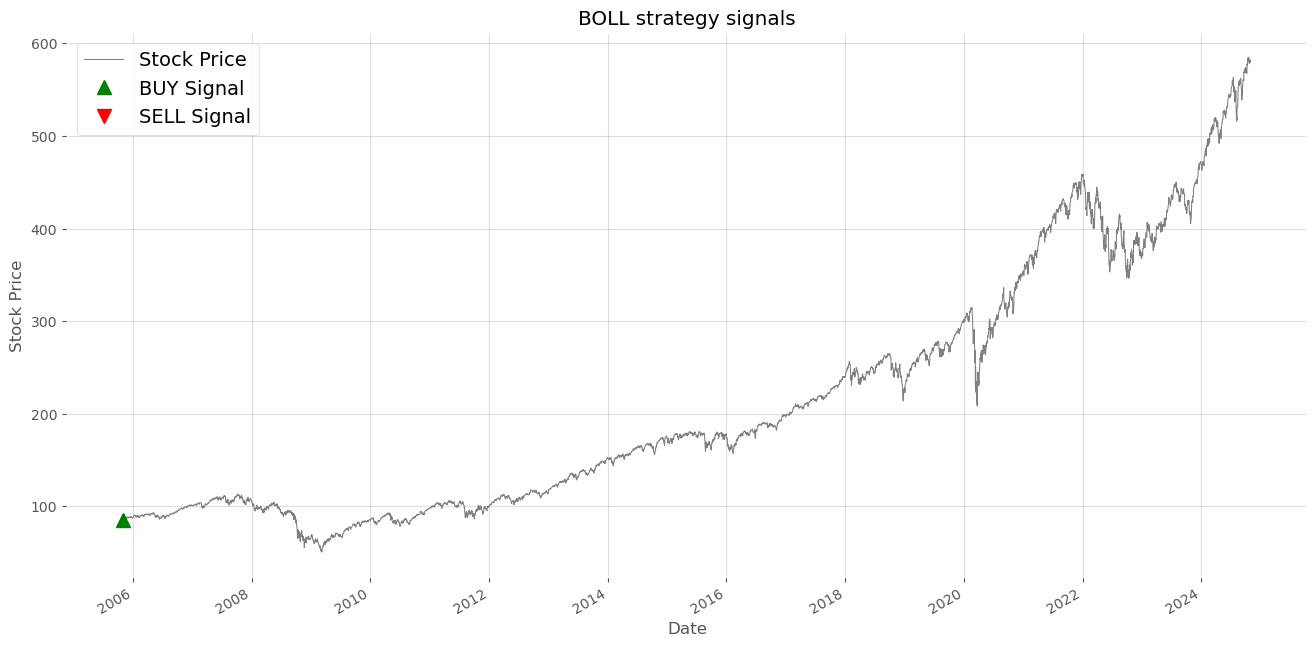

In [260]:
fig = plt.figure(figsize=[16, 8])
sub = fig.add_subplot(111, ylabel="Stock Price")

# Plot stock price
spy_df["Adj Close"].plot(ax=sub, color="grey", linewidth=0.75, label="Stock Price")

#BUY
sub.plot(
    spy_df.loc[spy_df['BOLL_trading_position'] == 2.0].index,  # x-axis: Dates
    spy_df.loc[spy_df['BOLL_trading_position'] == 2.0, "Adj Close"],  # y-axis: Prices
    "^",  # Marker
    color="green",
    markersize=10,
    label="BUY Signal"
)

#SELL
sub.plot(
    spy_df.loc[spy_df['BOLL_trading_position'] == -2.0].index,  # x-axis: Dates
    spy_df.loc[spy_df['BOLL_trading_position'] == -2.0, "Adj Close"],  # y-axis: Prices
    "v",  # Marker
    color="red",
    markersize=10,
    label="SELL Signal"
)
plt.title('BOLL strategy signals')
sub.legend(loc="best")
plt.show()


## <a id = "p8">1.3 </a> <font color = "green"> Combined Strategy </font>  [back to table of contents](#top)

### <a id = "p9">1.3.1 </a> <font color = "green"> SMA+CMO Strategy¶ </font>  [back to table of contents](#top) / [Backtesting result](#18)

In [261]:
spy_df['SMA_CMO_trading_position'] =spy_df['SMA_trading_position'] + spy_df['CMO_trading_position']

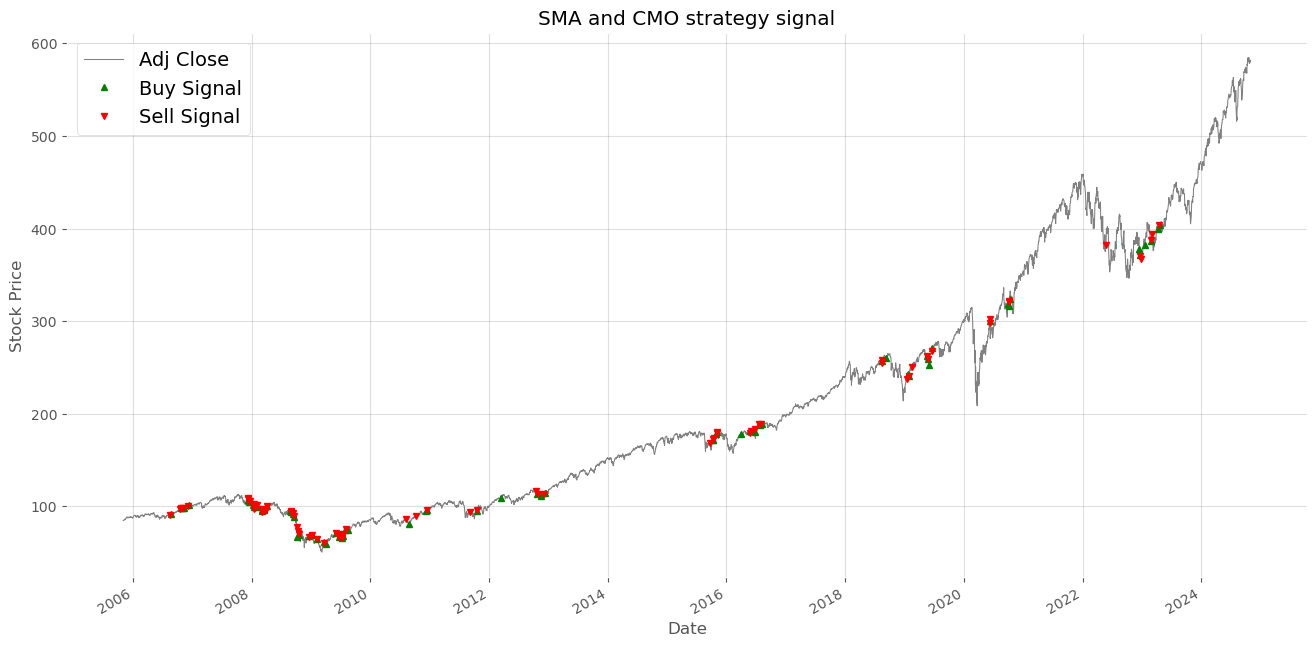

In [262]:
fig = plt.figure(figsize=[16, 8])

sub = fig.add_subplot(111, ylabel="Stock Price")

# Plot the stock prices
spy_df["Adj Close"].plot(ax=sub, color="grey", linewidth=0.75)

# BUY signal
sub.plot(
    spy_df.loc[spy_df['SMA_CMO_trading_position'] == 2.0].index,
    spy_df.loc[spy_df['SMA_CMO_trading_position'] == 2.0, "Adj Close"],
    "^",
    color="green",
    markersize=5,
    label="Buy Signal",
)

# SELL signal
sub.plot(
    spy_df.loc[spy_df['SMA_CMO_trading_position'] == -2.0].index,
    spy_df.loc[spy_df['SMA_CMO_trading_position'] == -2.0, "Adj Close"],
    "v",
    color="red",
    markersize=5,
    label="Sell Signal",
)

# Add legend
sub.legend()

plt.title('SMA and CMO strategy signal')
plt.show()


### <a id = "p10">1.3.2 </a> <font color = "green"> SMA+CMO+VIX Strategy¶ </font>  [back to table of contents](#top) / [Backtesting result](#19)

In [263]:
spy_df['SMA_CMO_VIX_trading_position'] = spy_df['SMA_CMO_trading_position'] + spy_df['VIX_trading_position']

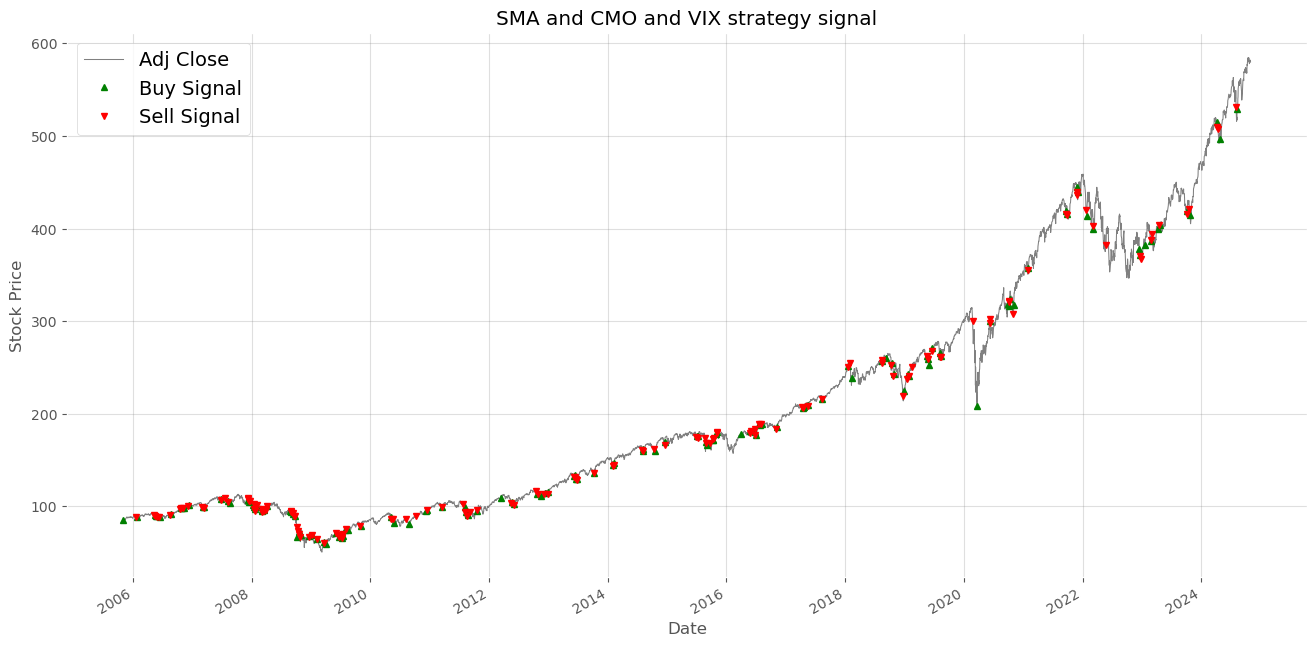

In [264]:


# Create the figure and subplot
fig = plt.figure(figsize=[16, 8])
sub = fig.add_subplot(111, ylabel="Stock Price")

# Plot the stock price
spy_df["Adj Close"].plot(ax=sub, color="grey", linewidth=0.75)

# BUY signal
sub.plot(
    spy_df.loc[spy_df['SMA_CMO_VIX_trading_position'] == 2.0].index, 
    spy_df.loc[spy_df['SMA_CMO_VIX_trading_position'] == 2.0, "Adj Close"], 
    "^", 
    color="green", 
    markersize=5,
    label="Buy Signal"
)

# SELL signal
sub.plot(
    spy_df.loc[spy_df['SMA_CMO_VIX_trading_position'] == -2.0].index, 
    spy_df.loc[spy_df['SMA_CMO_VIX_trading_position'] == -2.0, "Adj Close"], 
    "v", 
    color="red", 
    markersize=5,
    label="Sell Signal"
)

# Add legend
sub.legend()

plt.title('SMA and CMO and VIX strategy signal')
plt.show()


## <a id = "p11">1.4 </a> <font color = "green"> Machine Learning </font>  [back to table of contents](#top) / [Backtesting result](#20)

In [265]:
stock_ticker = ['SPY']
index_ticker = ['^VIX', 'SPY']
bond_ticker = ['ES=F']
start = dt.datetime(2005, 11, 1)
end = dt.datetime(2024, 10, 31)
stock_data = yf.download(stock_ticker, start = start, end = end)
index_data = yf.download(index_ticker, start = start, end = end)
bond_data = yf.download(bond_ticker, start = start, end = end)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  1 of 1 completed


In [266]:
# Compute weekly returns
return_period = 5

In [267]:
Y =\
    (np
     .log(index_data.loc[ : , ("Adj Close", "SPY")]
         )
     .diff(return_period)
     .shift(-return_period)
    )

Y

Date
2005-11-01    0.014338
2005-11-02    0.005243
2005-11-03    0.008714
2005-11-04    0.013422
2005-11-07    0.011873
                ...   
2024-10-24         NaN
2024-10-25         NaN
2024-10-28         NaN
2024-10-29         NaN
2024-10-30         NaN
Name: (Adj Close, SPY), Length: 4781, dtype: float64

In [268]:
Y.name =\
    (Y
     .name[-1]
     +
     "_pred")

Y.tail(10)

Date
2024-10-17   -0.005355
2024-10-18   -0.009539
2024-10-21   -0.004809
2024-10-22   -0.002661
2024-10-23    0.003489
2024-10-24         NaN
2024-10-25         NaN
2024-10-28         NaN
2024-10-29         NaN
2024-10-30         NaN
Name: SPY_pred, dtype: float64

In [269]:
index_data

Price        Adj Close                  Close                   High  \
Ticker             SPY       ^VIX         SPY       ^VIX         SPY   
Date                                                                   
2005-11-01   83.991135  14.850000  120.489998  14.850000  120.900002   
2005-11-02   84.869461  13.480000  121.750000  13.480000  121.750000   
2005-11-03   85.231911  13.000000  122.269997  13.000000  122.660004   
2005-11-04   85.120407  13.170000  122.110001  13.170000  122.459999   
2005-11-07   85.204094  13.100000  122.230003  13.100000  122.620003   
...                ...        ...         ...        ...         ...   
2024-10-24  579.239990  19.080000  579.239990  19.080000  580.059998   
2024-10-25  579.039978  20.330000  579.039978  20.330000  584.460022   
2024-10-28  580.830017  19.799999  580.830017  19.799999  582.710022   
2024-10-29  581.770020  19.340000  581.770020  19.340000  582.909973   
2024-10-30  580.010010  20.350000  580.010010  20.350000  583.320007   

Price                         Low                   Open               Volume  \
Ticker           ^VIX         SPY       ^VIX         SPY       ^VIX       SPY   
Date                                                                            
2005-11-01  15.660000  120.220001  14.650000  120.580002  14.850000  66365100   
2005-11-02  14.990000  120.129997  13.380000  120.169998  14.990000  74012300   
2005-11-03  13.230000  121.750000  12.500000  122.150002  13.120000  84897600   
2005-11-04  13.620000  121.550003  12.690000  122.400002  12.880000  59156000   
2005-11-07  13.650000  121.849998  12.760000  122.370003  13.110000  46765400   
...               ...         ...        ...         ...        ...       ...   
2024-10-24  20.240000  576.570007  18.629999  579.979980  18.870001  34979900   
2024-10-25  20.510000  578.080017  18.230000  581.510010  19.219999  47268200   
2024-10-28  19.879999  580.520020  18.910000  582.580017  19.110001  30174700   
2024-10-29  20.530001  578.429993  19.059999  579.849976  19.750000  42899700   
2024-10-30  20.440001  579.289978  19.299999  581.289978  19.330000  41435800   

Price            
Ticker     ^VIX  
Date             
2005-11-01    0  
2005-11-02    0  
2005-11-03    0  
2005-11-04    0  
2005-11-07    0  
...         ...  
2024-10-24    0  
2024-10-25    0  
2024-10-28    0  
2024-10-29    0  
2024-10-30    0  

[4781 rows x 12 columns]

In [270]:
X1 =\
    (np.
     log(index_data.loc[ : , ("Adj Close", ("SPY", "^VIX")
                             )
                       ]
        )
     .diff(return_period)
    )
X1.columns =\
    (X1
     .columns
     .droplevel()
    )


X2 = (
    np.log(
        bond_data['Adj Close']
    )
    .diff()
)

if isinstance(X2, pd.Series):
    X2 = X2.to_frame()
    X2.columns = ["ESF"]


X3 =\
    (
    pd
    .concat([np
             .log(index_data.loc[ : , ("Adj Close", "^VIX")
                                ]
                 )
             .diff(i) for i in [return_period, 
                                return_period * 3, 
                                return_period * 6, 
                                return_period * 12]
            ],
           axis = 1
           )
    .dropna()
)

X3.columns = ["VIX_DT", "VIX_3DT", "VIX_6DT", "VIX_12DT"]
X=\
(
    pd
    .concat([X1, X2, X3],
            axis=1)
)

X.head(60)
data =\
(
pd
.concat([Y, X],
        axis =1)
.dropna()
.iloc[ : :return_period, :]
)
Y = data.loc[ : , Y.name]
X = data.loc[ : , X.columns]

In [271]:
Y.head()

Date
2006-01-30   -0.014429
2006-02-06   -0.001502
2006-02-13    0.016320
2006-02-21   -0.002025
2006-02-28   -0.002030
Name: SPY_pred, dtype: float64

In [272]:
X.head()

,SPY,^VIX,ESF,VIX_DT,VIX_3DT,VIX_6DT,VIX_12DT
Date,,,,,,,
2006-01-30,0.015852,-0.117155,-0.000582,-0.117155,0.118994,0.167421,-0.181110
2006-02-06,-0.014429,0.051132,0.002565,0.051132,0.149433,0.187550,-0.003063
2006-02-13,-0.001502,0.023495,-0.001973,0.023495,-0.042528,0.139650,0.087625
2006-02-21,0.016320,-0.073014,-0.002720,-0.073014,0.001613,0.120607,0.157649
2006-02-28,-0.002025,-0.005657,-0.008927,-0.005657,-0.055176,0.094257,0.022952


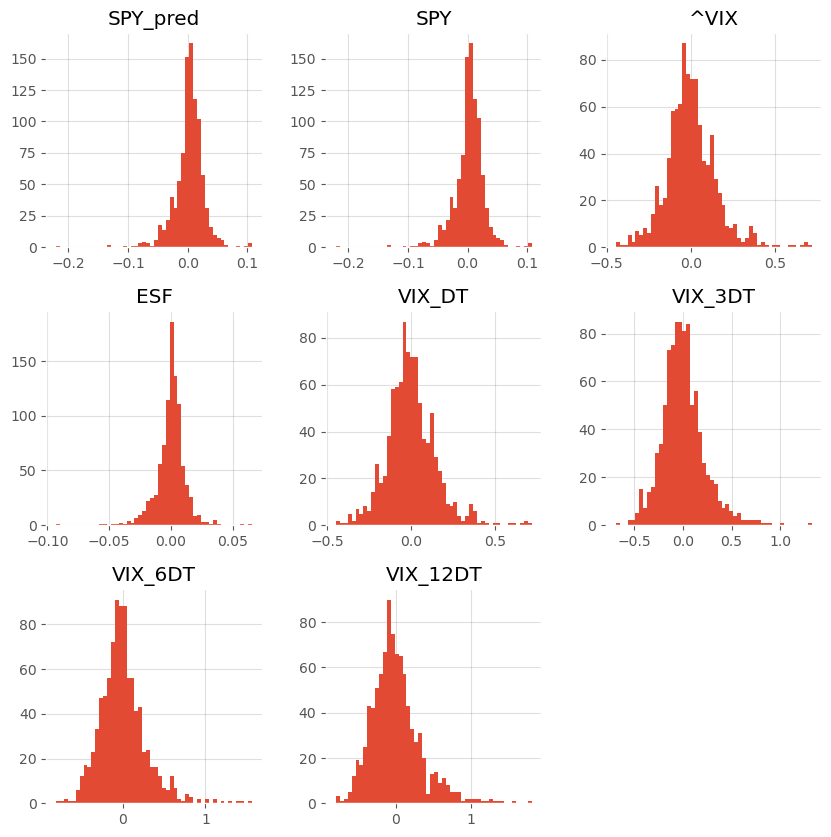

In [273]:
(data
 .hist(bins = 50,
       sharex = False,
       sharey = False,
       figsize =[10, 10]
      )
)
plt.show()

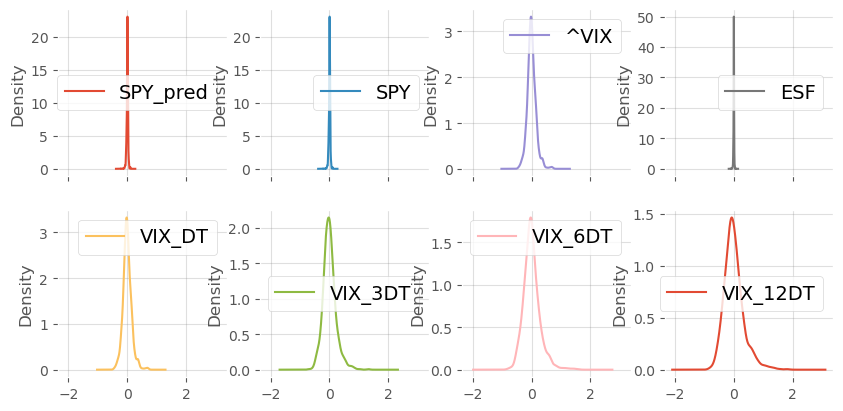

In [274]:
(
    data.
    plot(kind = "density",
         subplots = True,
         layout = (4, 4),
         sharex = True,
         legend = True,
         figsize = [10, 10]
        )
)

plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

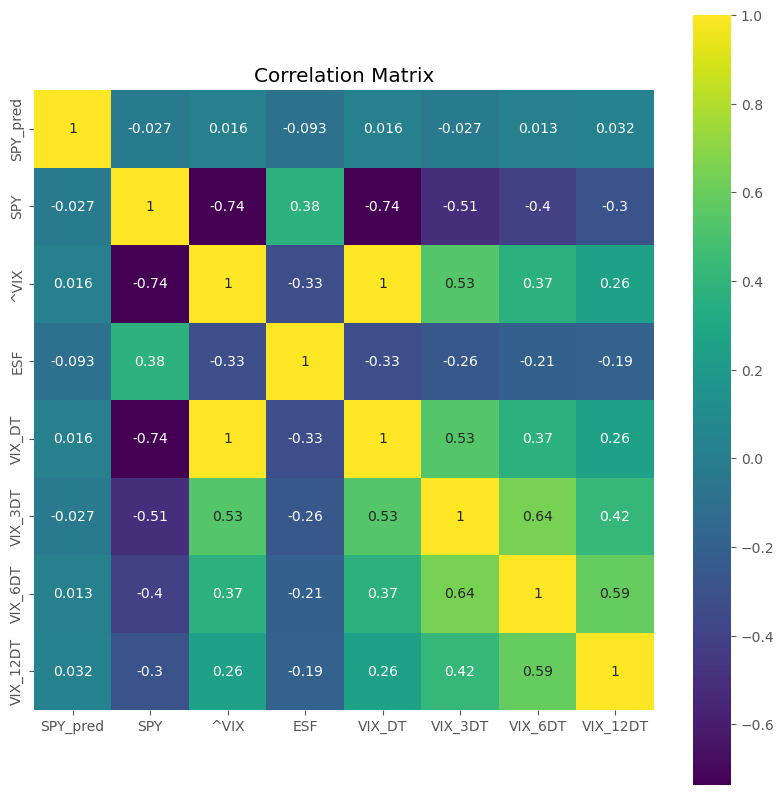

In [275]:
correlation = data.corr()

plt.figure(figsize =[10, 10]
          )

plt.title("Correlation Matrix")

sns.heatmap(correlation,
            vmax = 1,
            square = True,
            cmap = "viridis",
            annot = True)

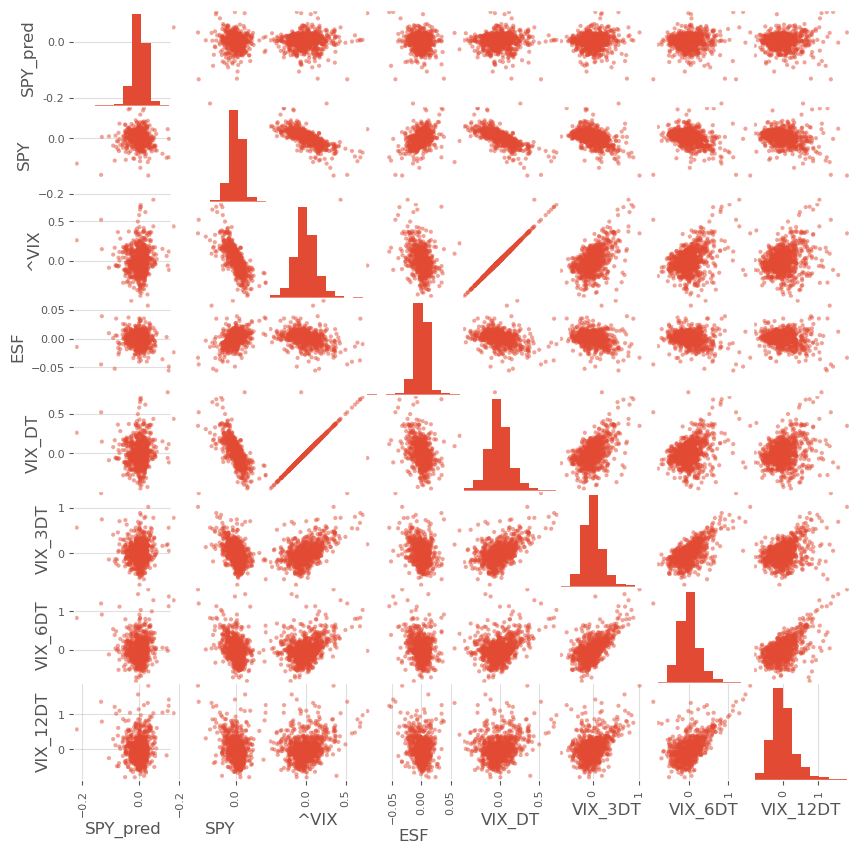

In [276]:
scatter_matrix(data,
               figsize = (10, 10)
              )
plt.show()

In [277]:
# Doing the train-test split without using the API
validation_size = 0.20

train_size =\
    int(len(X) 
        * 
        (1 - validation_size)
       )

X_train, X_test =\
    (X[0         :train_size], 
     X[train_size:len(X)    ]
    )

Y_train, Y_test =\
    (Y[0         :train_size], 
     Y[train_size:len(X)    ]
    )

In [278]:

models = []
models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso()
             )
            )

models.append(("EN", ElasticNet()
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )


models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()
              )
             )


models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )

In [279]:
num_folds = 10
seed = 241001
scoring = "neg_mean_squared_error"

In [280]:
names = []
kfold_results = []
train_results = []
test_results = []


for name, model in models:

    names.append(name)

    kfold =\
        (KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        )
    cv_results =\
        (
         -1 # doing this since we're using neg_mean_squared_error
         *
         cross_val_score(model, X_train, Y_train,
                         cv = kfold,
                         scoring = scoring)
        )
        

    kfold_results.append(cv_results)
    res = model.fit(X_train, Y_train) 

# Evaluating Model on Training Set:
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

# Evaluating Model on Testing Set:          
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
# Printing the Results:
    message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
                                     cv_results.std(), 
                                     train_result, 
                                     test_result)
    print(message)

LR: 0.000683 (0.000266) 0.000645 0.000512
LASSO: 0.000656 (0.000277) 0.000655 0.000515
EN: 0.000656 (0.000277) 0.000655 0.000515
CART: 0.001350 (0.000286) 0.000000 0.001175
KNN: 0.000735 (0.000238) 0.000491 0.000611
SVR: 0.001022 (0.000263) 0.000904 0.000893
RFR: 0.000786 (0.000290) 0.000105 0.000664
ETR: 0.000783 (0.000271) 0.000000 0.000546
GBR: 0.000778 (0.000241) 0.000254 0.000627
ABR: 0.000792 (0.000272) 0.000494 0.000613


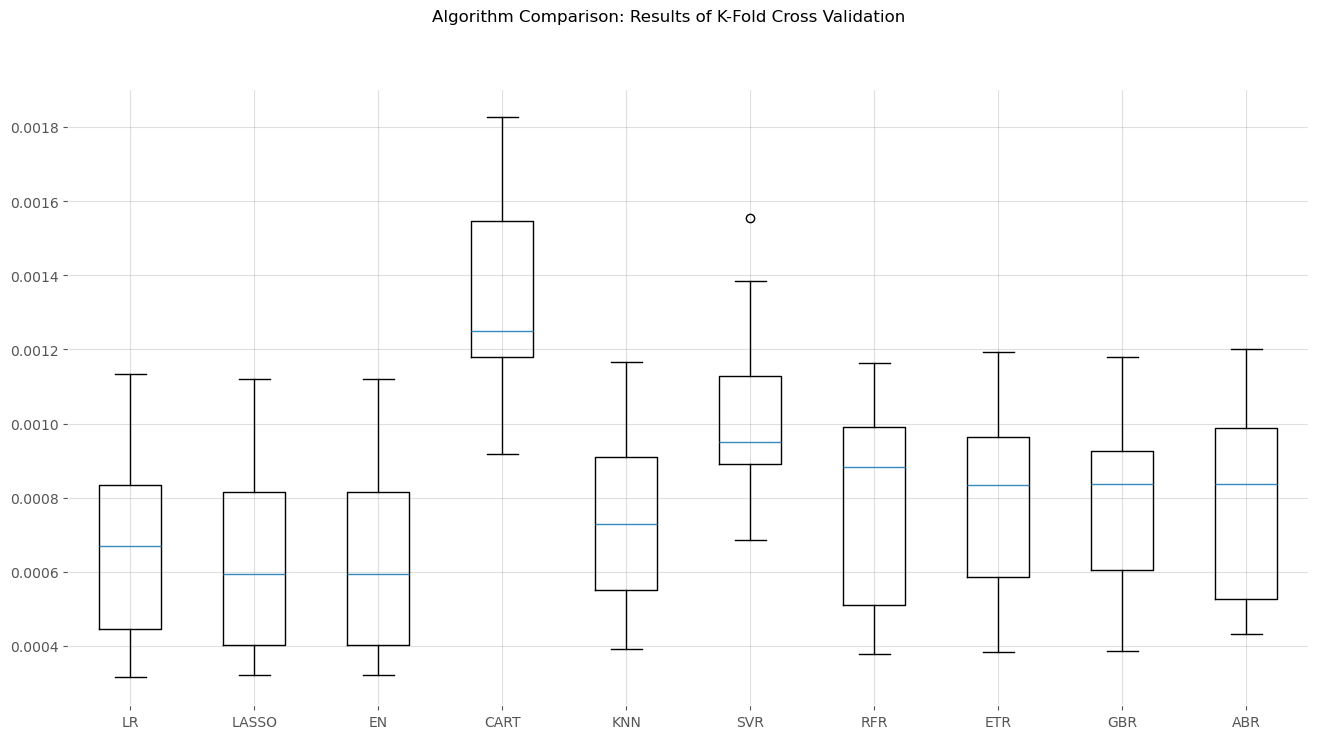

In [281]:
# Comparing the algorithms using the results of the K-Fold Cross Validation

fig = plt.figure(figsize = [16, 8]
                )

fig.suptitle("Algorithm Comparison: Results of K-Fold Cross Validation")

ax = fig.add_subplot(111)

plt.boxplot(kfold_results)

ax.set_xticklabels(names)

plt.show()

In [282]:
X_train_ARIMA =\
    (X_train
    .loc[ : , ['^VIX', 'ESF', 'VIX_DT', 'VIX_3DT', 'VIX_6DT','VIX_12DT']]
   )

X_test_ARIMA =\
    (X_test
    .loc[ : , [ '^VIX', 'ESF', 'VIX_DT', 'VIX_3DT', 'VIX_6DT','VIX_12DT']]
)    

train_len = len(X_train_ARIMA)
test_len = len(X_test_ARIMA)
total_len = len(X)

In [283]:
modelARIMA =\
(    stats
     .ARIMA(endog = Y_train,
                exog = X_train_ARIMA,
                order = [1, 0, 0]
            )
)

model_fit = modelARIMA.fit()

In [284]:
error_training_ARIMA =\
(    mean_squared_error(Y_train,
                       model_fit.fittedvalues)
)



In [285]:
predicted =\
(
    model_fit
    .predict(start = train_len - 1,
             end = total_len - 1,
             exog = X_test_ARIMA)[1: ]
)

In [286]:
error_testing_ARIMA =\
(    mean_squared_error(Y_test,
                        predicted)
)

error_testing_ARIMA

0.0005125358824496573

In [287]:
test_results.append(error_testing_ARIMA)

train_results.append(error_training_ARIMA)

names.append("ARIMA")

In [288]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=names,
    y=train_results,
    name='Errors in Training Set',
    marker=dict(color='red'),
    offsetgroup=0
))

fig.add_trace(go.Bar(
    x=names,
    y=test_results,
    name='Errors in Testing Set',
    marker=dict(color='blue'), 
    offsetgroup=1
))

fig.update_layout(
    title='Comparing the Performance of Various Algorithms on the Training vs. Testing Data',
    xaxis=dict(title='Models'),
    yaxis=dict(title='Mean Squared Error (MSE)'),
    barmode='group',
    legend=dict(title='Error Type')
)

fig.show()

In [289]:
# Hyperparameter Tuning

def assess_ARIMA_model(arima_order):
    
    modelARIMA = stats.ARIMA(endog = Y_train, 
                             exog = X_train_ARIMA,
                             order = arima_order)    
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train,
                               model_fit.fittedvalues)
    return error

def assess_models(p_values, d_values, q_values):
    
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = assess_ARIMA_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    
                    print("ARIMA%s MSE = %.7f" % (order, mse)
                          )
                    
                except:
                    continue
    print("Best ARIMA%s MSE = %.7f" % (best_cfg, best_score)
          )

p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)

In [290]:
assess_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE = 0.0006448
ARIMA(0, 0, 1) MSE = 0.0006446
ARIMA(0, 1, 0) MSE = 0.0010237
ARIMA(0, 1, 1) MSE = 0.0006488
ARIMA(1, 0, 0) MSE = 0.0006446
ARIMA(1, 0, 1) MSE = 0.0006446
ARIMA(1, 1, 0) MSE = 0.0008335
ARIMA(1, 1, 1) MSE = 0.0006490
ARIMA(2, 0, 0) MSE = 0.0006446
ARIMA(2, 0, 1) MSE = 0.0006446
ARIMA(2, 1, 0) MSE = 0.0008067
ARIMA(2, 1, 1) MSE = 0.0006592
Best ARIMA(1, 0, 1) MSE = 0.0006446


In [291]:
ARIMA_Tuned =\
    stats \
    .ARIMA(endog = Y_train,
           exog = X_train_ARIMA,
           order = [1, 0, 1] # Set the optimal parameters here
          )

ARIMA_Fit_Tuned = ARIMA_Tuned.fit()

In [292]:
Predicted_Tuned =\
    model_fit \
    .predict(start = train_len - 1,
             end = total_len - 1,
             exog = X_test_ARIMA)[1:]

In [293]:
print(mean_squared_error(Y_test,
                         Predicted_Tuned)
     )

0.0005125358824496573


In [294]:
Predicted_Tuned.index = Y_test.index

actual_cum_returns = Y_test.cumsum().apply(np.exp)
predicted_cum_returns = Predicted_Tuned.cumsum().apply(np.exp)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=actual_cum_returns.index,
    y=actual_cum_returns,
    mode='lines',
    name='Actual Y - SPY cum returns',
    line=dict(color='blue', dash='dash')
))

fig.add_trace(go.Scatter(
    x=predicted_cum_returns.index,
    y=predicted_cum_returns,
    mode='lines',
    name='SPY predicted returns',
    line=dict(color='red')
))

fig.update_layout(
    title="Cumulative Returns: Actual vs Predicted",
    xaxis_title="Date",
    yaxis_title="Cumulative Returns",
    template='plotly_white',
    width=1200,
    height=800,
    legend=dict(x=0, y=1.0)
)

fig.show()

In [295]:
# BUY SIGNAL
Buy_Signal = actual_cum_returns < (predicted_cum_returns - predicted_cum_returns.std())
Buy_Signal.value_counts()

False    143
True      46
Name: count, dtype: int64

In [296]:
# We buy at the very beginning of the prediction period as well.
Buy_Signal.iloc[0] = True 
Buy_Signal


Date
2021-01-25     True
2021-02-01    False
2021-02-08    False
2021-02-16    False
2021-02-23    False
              ...  
2024-09-20    False
2024-09-27    False
2024-10-04    False
2024-10-11    False
2024-10-18    False
Length: 189, dtype: bool

In [297]:
#Sell Signal
n = 1.5
N = 1.5

Unwind_Signal = (actual_cum_returns > (predicted_cum_returns + predicted_cum_returns.std()))
print(Unwind_Signal.value_counts())

False    163
True      26
Name: count, dtype: int64


In [298]:
spy_ml = pd.DataFrame()
spy_ml = spy_ml.reindex(Y_test.index)

spy_ml['ml_position'] = np.where(
    actual_cum_returns < (predicted_cum_returns - predicted_cum_returns.std()), 1, np.nan
)

spy_ml['ml_position'] = np.where(
    actual_cum_returns > (predicted_cum_returns + predicted_cum_returns.std()), -1, spy_ml['ml_position']
)
spy_ml['ml_position'][0]=1
spy_ml['ml_position']=spy_ml['ml_position'].ffill()

In [299]:
spy_ml['ml_trading__position'] = spy_ml['ml_position'].diff()

In [300]:
spy_ml['ml_trading__position'][0]=2

In [301]:
spy_ml['log_return'] = Y_test

In [302]:
spy_ml

,ml_position,ml_trading__position,log_return
Date,,,
2021-01-25,1.0,2.0,-0.021457
2021-02-01,1.0,0.0,0.037253
2021-02-08,1.0,0.0,0.004573
2021-02-16,1.0,0.0,-0.012311
2021-02-23,1.0,0.0,-0.002481
...,...,...,...
2024-09-20,-1.0,0.0,0.005650
2024-09-27,-1.0,0.0,0.002639
2024-10-04,-1.0,0.0,0.011453


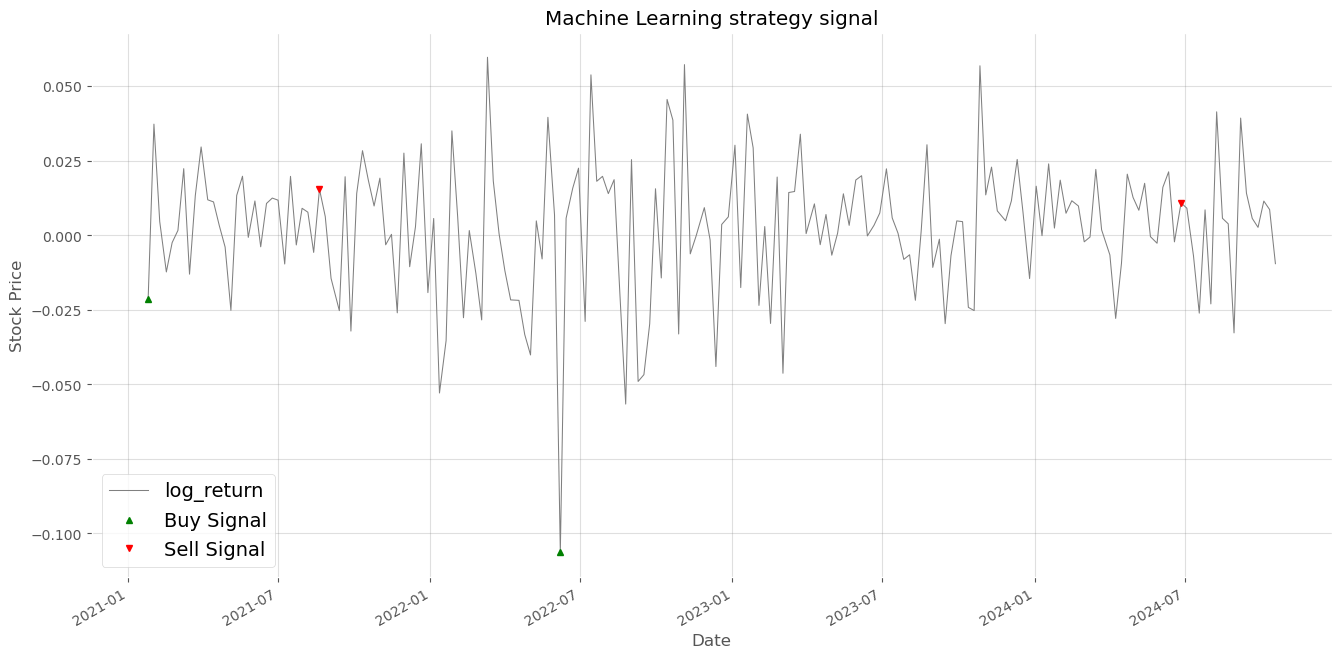

In [303]:


# Create the figure and subplot
fig = plt.figure(figsize=[16, 8])
sub = fig.add_subplot(111, ylabel="Stock Price")

# Plot the stock price
spy_ml["log_return"].plot(ax=sub, color="grey", linewidth=0.75)

# BUY signal
sub.plot(
    spy_ml.loc[spy_ml['ml_trading__position'] == 2.0].index, 
    spy_ml.loc[spy_ml['ml_trading__position'] == 2.0, "log_return"], 
    "^", 
    color="green", 
    markersize=5,
    label="Buy Signal"
)

# SELL signal
sub.plot(
    spy_ml.loc[spy_ml['ml_trading__position'] == -2.0].index, 
    spy_ml.loc[spy_ml['ml_trading__position'] == -2.0, "log_return"], 
    "v", 
    color="red", 
    markersize=5,
    label="Sell Signal"
)

# Add legend
sub.legend()

plt.title('Machine Learning strategy signal')
plt.show()


# <a id = "p12"> </a> <font color = "green"> PART2 BACKTESTING </font>  [back to table of contents](#top)

## <a id = "p13">2.1 </a> <font color = "green"> Simple Moving Average backtest </font>  [back to table of contents](#top)

SMA performance metric

Final Portfolio Value: $741784.24
Total Return: 641.78%
Sharpe Ratio: 0.80
CAGR: 11.12%
Maximum Drawdown: -33.72%


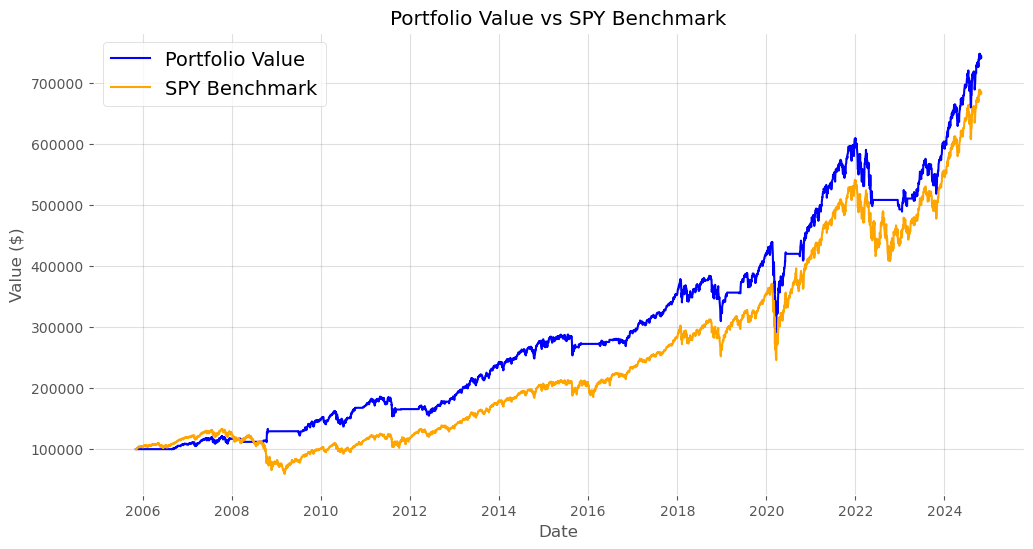

In [304]:
print('SMA performance metric')
long_and_hold_backtest(spy_df,100000,'SMA_trading_position','Adj Close')

## <a id = "p14">2.2 </a> <font color = "green"> Exponential Moving Average backtest </font>  [back to table of contents](#top)

EMA performance metric

Final Portfolio Value: $688472.52
Total Return: 588.47%
Sharpe Ratio: 0.77
CAGR: 10.68%
Maximum Drawdown: -33.72%


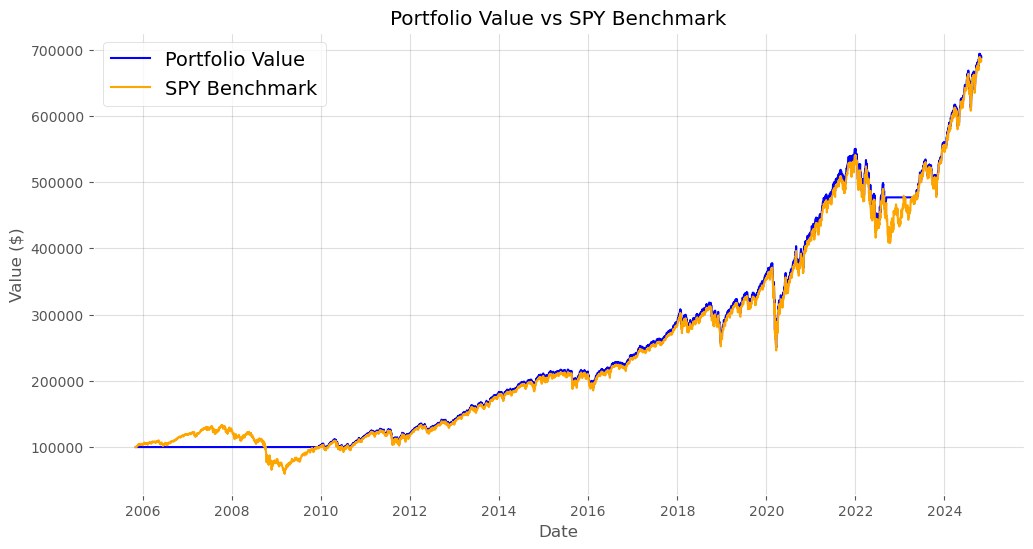

In [305]:
print('EMA performance metric')
long_and_hold_backtest(spy_df,100000,'EMA_trading_position','Adj Close')

## <a id = "p15">2.3 </a> <font color = "green"> Chande Momentum Oscillator backtest </font>  [back to table of contents](#top)

CMO performance metric

Final Portfolio Value: $1222404.35
Total Return: 1122.40%
Sharpe Ratio: 0.82
CAGR: 14.08%
Maximum Drawdown: -33.72%


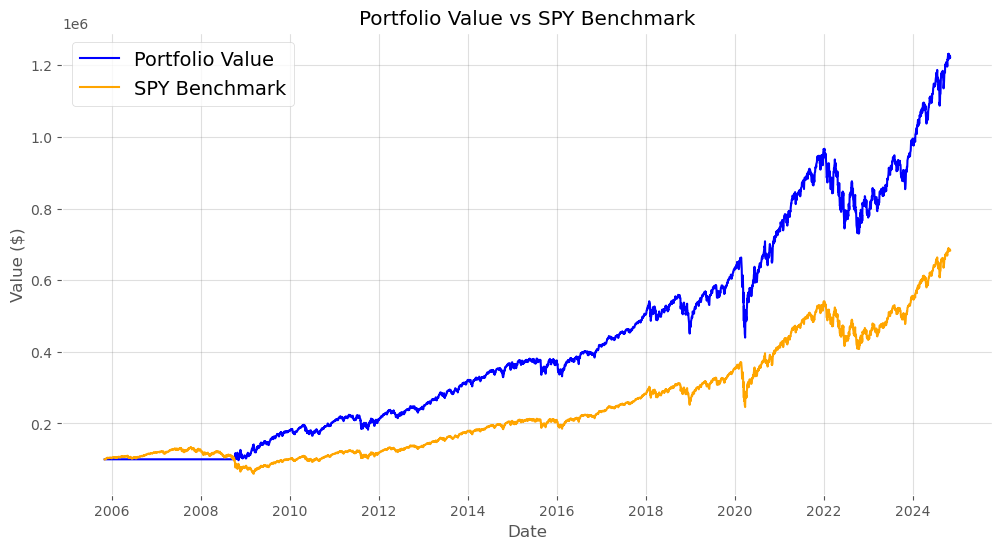

In [306]:
print('CMO performance metric')
long_short_sell_backtest(spy_df,100000,'CMO_trading_position','Adj Close')

## <a id = "p16">2.4 </a> <font color = "green"> VIX backtest </font>  [back to table of contents](#top)

VIX performance metric

Final Portfolio Value: $9550631.10
Total Return: 9450.63%
Sharpe Ratio: 1.40
CAGR: 27.11%
Maximum Drawdown: -31.62%


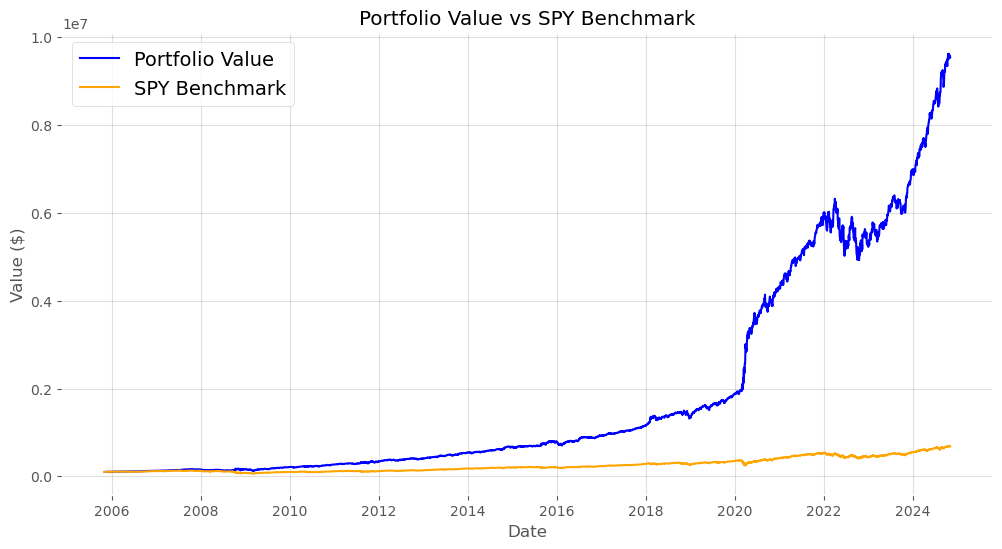

In [307]:
print('VIX performance metric')
long_short_sell_backtest(spy_df,100000,'VIX_trading_position','Adj Close')

## <a id = "p17">2.5 </a> <font color = "green"> Bollinger band backtest </font>  [back to table of contents](#top)

BOllinger Band performance metric

Final Portfolio Value: $683414.27
Total Return: 583.41%
Sharpe Ratio: 0.62
CAGR: 10.64%
Maximum Drawdown: -55.19%


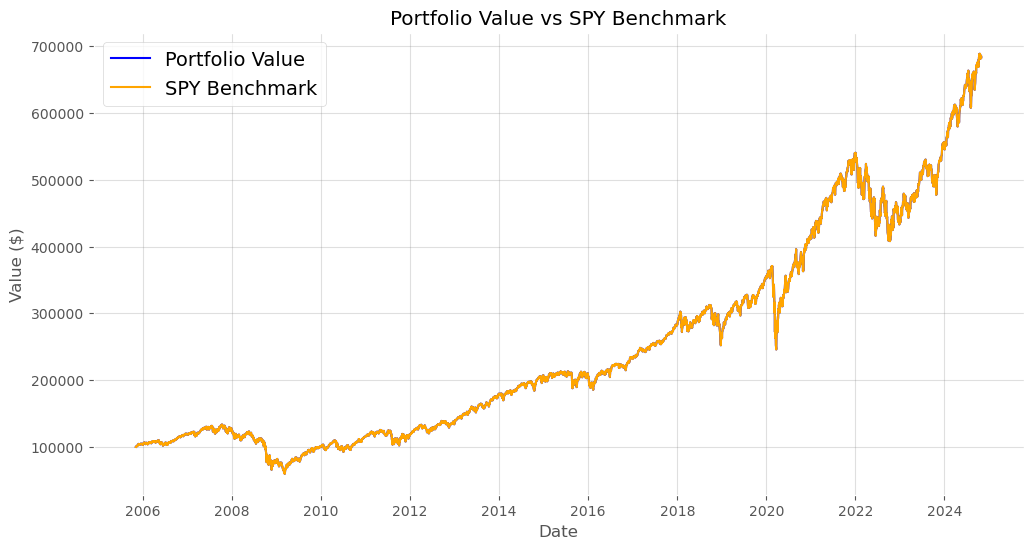

In [308]:
print('BOllinger Band performance metric')
long_short_sell_backtest(spy_df,100000,'BOLL_trading_position','Adj Close')

## <a id = "p18">2.6 </a> <font color = "green"> SMA and CMO backtest </font>  [back to table of contents](#top)

SMA and CMO performance metric

Final Portfolio Value: $813466.25
Total Return: 713.47%
Sharpe Ratio: 0.68
CAGR: 11.66%
Maximum Drawdown: -33.72%


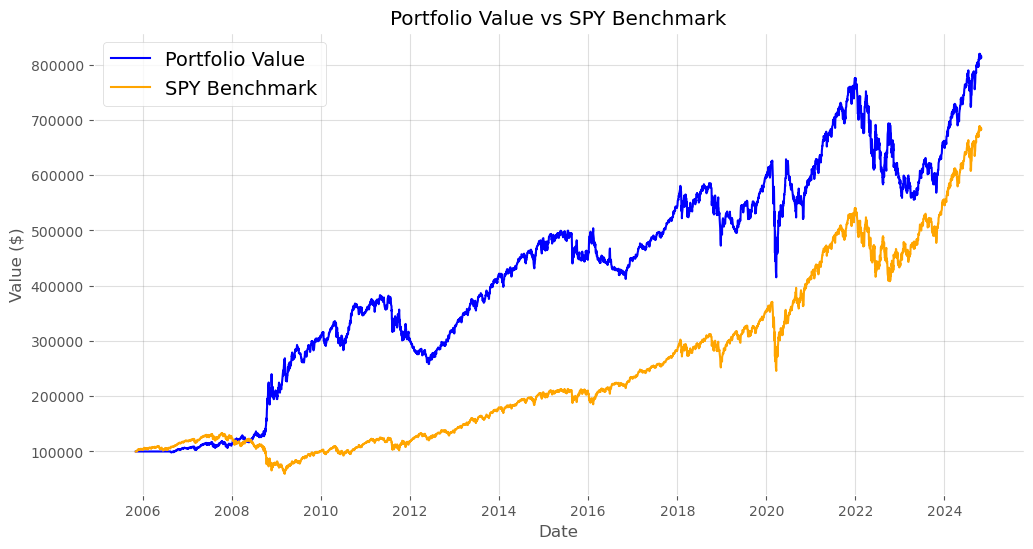

In [309]:
print('SMA and CMO performance metric')
long_short_sell_backtest(spy_df,100000,'SMA_CMO_trading_position','Adj Close')

## <a id = "p19">2.7 </a> <font color = "green"> SMA and CMO and VIX backtest </font>  [back to table of contents](#top)

SMA and CMO and VIX performance metric

Final Portfolio Value: $9631085.75
Total Return: 9531.09%
Sharpe Ratio: 1.42
CAGR: 27.17%
Maximum Drawdown: -26.12%


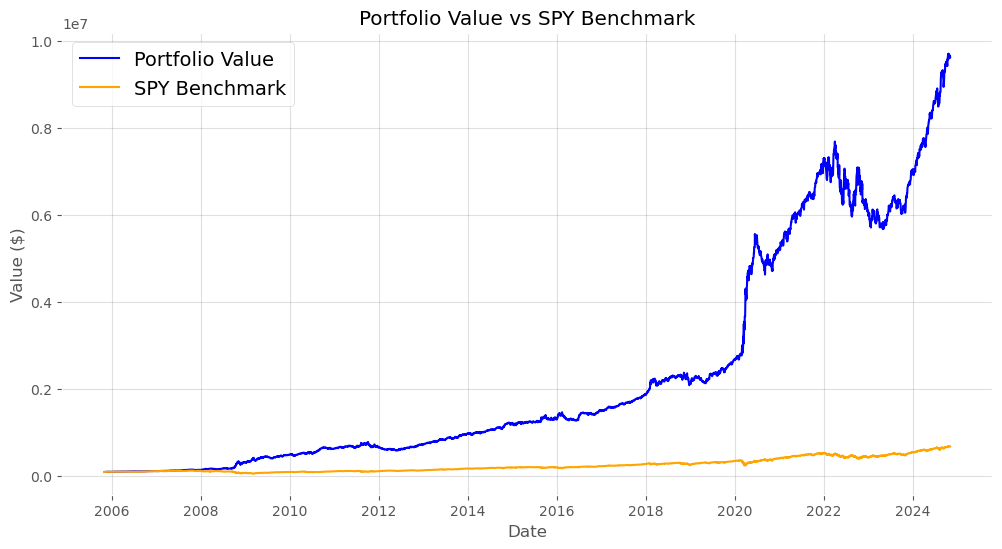

In [310]:
print('SMA and CMO and VIX performance metric')
long_short_sell_backtest(spy_df,100000,'SMA_CMO_VIX_trading_position','Adj Close')

## <a id = "p20">2.8</a> <font color = "green"> Machine Learning backtest </font>  [back to table of contents](#top)

In [311]:
spy_ml['ml_trading__position'].unique()

array([ 2.,  0., -2.])


Final Portfolio Value: $208219.19
Total Return: 108.22%
Sharpe Ratio: 2.90
CAGR: 21.74%
Maximum Drawdown: -16.18%


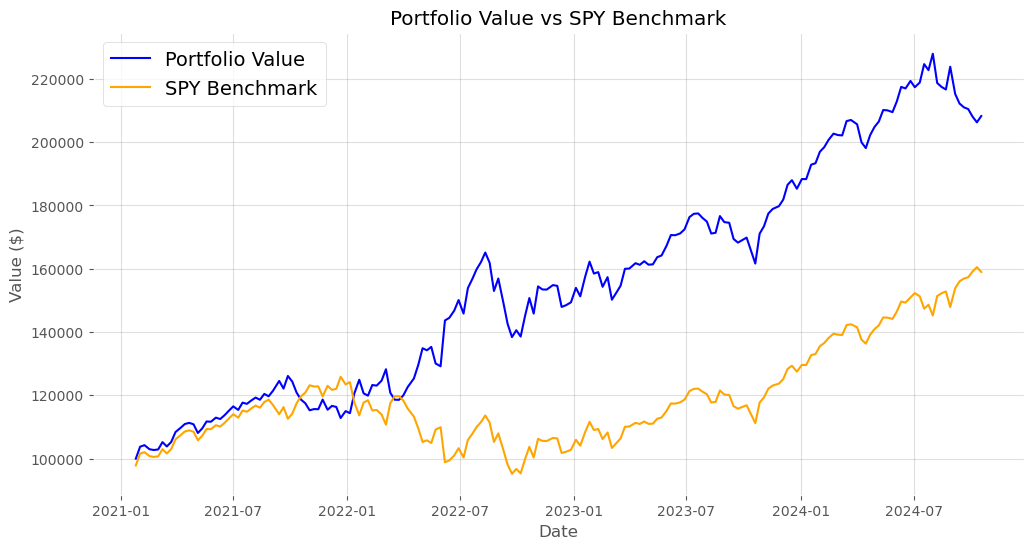

In [312]:
ml_backtest(spy_ml, 100000, 'ml_trading__position', 'log_return')

## <a id = "p21">3</a> <font color = "green"> EXECUTIVE SUMMARY </font>  [back to table of contents](#top)

### QF627 Take Home Assignment

The goal of this assignment is to **beat the SPY** using one or a combination of the following strategies:
- Momentum Trading Strategies
- Mean-Reversion Strategies
- Machine Learning Models

### SPY Performance Metrics
- **Final Portfolio Value**: $683,414.27  
- **Total Return**: 583.41%  
- **Sharpe Ratio**: 0.62  
- **CAGR (Compound Annual Growth Rate)**: 10.64%  
- **Maximum Drawdown**: -55.19%


### Performance of Trading Strategies

We have employed the following trading strategies in an attempt to **beat the long-and-hold performance of SPY**:
- **4 Momentum Trading Strategies**
- **1 Mean-Reversion Strategy**
- **1 Machine Learning Trading Strategy**
- **2 Combined Trading Strategies**

#### Results:
- Out of these **8 trading strategies**, **7 outperformed SPY** in terms of returns.  
- The only strategy that fell short was the **mean-reversion strategy (Bollinger Band)**. This suggests that since SPY is a stock that trends, **mean reversion strategies are not effective**.

#### Top 3 Outperforming Strategies(based on returns):
1. **SMA, CMO, and VIX Combination**
2. **VIX**
3. **ARIMA-X Model**


## [1. SMA, CMO, and VIX Combined Strategy](#p19)

This is a **holistic trading strategy** that combines **SMA**, **CMO**, and **VIX** to identify market weaknesses and generate short signals. The strategy assumes a **default long position** due to SPY’s upward-trending momentum, incorporating both long and short sell positions.

### Components of the Strategy:
1. **Simple Moving Average (SMA):**
   - **Short SMA**: 151
   - **Long SMA**: 152  
   When the **Short SMA crosses below the Long SMA**, it signals a **short-term downward trend**, prompting a **short position**.

2. **Chande Momentum Oscillator (CMO):**
   - Applied to SPY's adjusted close price with a rolling window of 273
   - When the **CMO crosses below -10**, it indicates a **downtrend**, and the stock is shorted.

3. **VIX (Volatility Index):**
   - **90-day moving average** and **standard deviation** were calculated.
   - When the **VIX crosses above the 90-day moving average + 2 standard deviations**, it signals a **volatile market**, prompting a short position.

### Performance Metrics:
- **Initial Capital**: $100,000  
- **Final Portfolio Value**: $9,631,085.75  
- **Total Return**: 9531.09%  
- **Sharpe Ratio**: 1.42  
- **CAGR (Compound Annual Growth Rate)**: 27.17%  
- **Maximum Drawdown**: -26.12%

This strategy effectively leverages **momentum and volatility signals** to generate significant returns while maintaining a balanced risk profile.


## [2.VIX Strategy](#p16)

This trading strategy leverages **VIX (Volatility Index)** to identify volatile market conditions and generate short signals, while assuming a **default long position** due to SPY's upward-trending momentum. The strategy involves both **long** and **short sell positions**.

### Strategy Details:
- **Rolling Window**: 90 days.
- **Signals**: 
  - The **VIX moving average** and **standard deviation** are calculated over the rolling window.
  - When the **VIX crosses above** the **90-day moving average + 2 standard deviations**, it indicates a **volatile market**, generating a **short signal**.

### Performance Metrics:
- **Initial Capital**: $100,000  
- **Final Portfolio Value**: $9,550,631.10  
- **Total Return**: 9450.63%  
- **Sharpe Ratio**: 1.40  
- **CAGR (Compound Annual Growth Rate)**: 27.11%  
- **Maximum Drawdown**: -31.62%

This strategy capitalizes on volatility spikes to outperform SPY, achieving remarkable returns while maintaining a balanced approach to risk.


## [3.ARIMA-X Strategy](#p20)

This strategy utilizes an **ARIMA-X model** to predict the weekly returns of SPY, incorporating **VIX (Volatility Index)** and **Energy Futures (ES=F)** as exogenous variables (**X-variables**). The strategy involves both **long and short sell positions** based on deviations from model predictions.

### Strategy Details:
- **ARIMA-X Model**: (1, 0, 1)  
  This configuration was determined to be the optimal model.
- **X-Variables**:  
  - Lagged **VIX** (5, 15, 30, and 60 days).  
  - **ES=F (Energy Futures)**.
- **Signals**:  
  - The ARIMA-X model predicts the trend, acting as a **best-fit line** for SPY returns.  
  - **Short**: When the actual SPY return deviates **1 standard deviation above** the model prediction.  
  - **Long**: When the actual SPY return deviates **1 standard deviation below** the model prediction.

### Performance Metrics:
- **Initial Capital**: $100,000  
- **Final Portfolio Value**: $208,219.19  
- **Total Return**: 108.22%  
- **Sharpe Ratio**: 2.90  
- **CAGR (Compound Annual Growth Rate)**: 21.74%  
- **Maximum Drawdown**: -16.18%

This strategy leverages statistical modeling and predictive analytics to achieve **consistent returns** with a **high Sharpe ratio**, though it delivers more moderate gains compared to momentum-based strategies.


## Strategy Comparison and Analysis

### Best Return:
- **SMA, CMO, and VIX** trading strategy provides the **highest return** of **27.17%**, followed closely by the **VIX** strategy.  
- The **ARIMA-X** strategy, while delivering a lower return of **21.74%**, balances risk effectively.

### Best Sharpe Ratio:
- **ARIMA-X** has the **highest Sharpe Ratio** of **2.90**, more than **double** that of the second-best strategy, **SMA, CMO, and VIX** (**1.42**).

### Lowest Maximum Drawdown:
- **ARIMA-X** exhibits the **lowest maximum drawdown** of **16.18%**, outperforming:
  - **SMA, CMO, and VIX**: **26.12%**
  - Other strategies with higher drawdowns.

### Best Strategy:
The **best trading strategy** combines **high returns**, **a strong Sharpe Ratio**, and **low maximum drawdown**. While each strategy has its strengths:

- **SMA, CMO, and VIX**:
  - Highest Return: **27.17%**
  - Sharpe Ratio: **1.42**
  - Maximum Drawdown: **-26.12%**
- **ARIMA-X**:
  - Return: **21.74%**
  - Sharpe Ratio: **2.90**
  - Maximum Drawdown: **-16.18%**

#### Conclusion:
When accounting for **returns, risk, and drawdowns**, the [<span style="color:gold;">**ARIMA-X**</span>](#p20)
 strategy is the **overall best-performing trading strategy**. It provides **consistent returns**, the **lowest risk**, and the **highest Sharpe Ratio**, making it the most balanced choice for achieving optimal performance with minimal risk.


## <a id = "p22">4</a> <font color = "green"> SELF CRITIQUE AND DISCUSSION </font>  [back to table of contents](#top)

## <a id = "p23">4.1 </a> <font color = "green"> CMO and SMA and VIX reflection </font>  [back to table of contents](#top)

## Flaws in This Strategy

### Assumptions Underlying This Strategy
This trading strategy combines two momentum strategies with a volatility-based approach. However, several assumptions underlie its development, each introducing potential risks:

#### 1. Momentum Assumption for SPY
The strategy assumes that SPY is a momentum-driven stock that will always trend upwards. This assumption is based on the structural design of the S&P 500, which annually updates its constituents by including top-performing companies and removing underperformers. This allows for a reasonable belief that the S&P 500 acts as a momentum index.
- **Risk:** This exposes the strategy to the possibility of SPY behaving as a mean-reverting stock, particularly during periods of economic stagnation or structural shifts in the index composition.

#### 2. Volatility Assumption for VIX
The VIX strategy operates under the assumption that increased market volatility signals a downward movement in stock prices. This is based on the historical observation that volatility spikes often correspond to bear markets, with option prices rising as investors anticipate downturns.
- **Risk:** While often true, this assumption may fail during periods of heightened uncertainty that lead to sharp recoveries or intraday whipsaws, making VIX alone an unreliable indicator.

#### 3. Parameter Optimization and Overfitting
The strategy employs specific parameters for its indicators, such as SMA (151 and 152) and CMO (273 window). These values may be overly tuned to historical data, leading to overfitting.
- **Risk:** In live markets, these parameters may not generalize well, potentially reducing the strategy's effectiveness in real-world scenarios.

By relying on these assumptions, the strategy carries inherent risks tied to market behavior deviations, the limitations of volatility-based predictions, and potential overfitting. Recognizing and addressing these vulnerabilities is essential for refining the approach and enhancing its robustness.

---

### CMO: A Limited and Ineffective Strategy
The CMO strategy only generated signals during the 2008 Great Financial Crisis, demonstrating minimal responsiveness to broader market conditions. This suggests the strategy is only applicable during black swan events. However, it failed to identify key events like the COVID-19 pandemic and the 2022 recession scare, highlighting its ineffectiveness even as a black swan trading approach. Given its inability to perform reliably, this strategy should be removed from consideration entirely.

---

### Limitations of a Technical Indicator-Based Strategy
This trading strategy relies exclusively on technical indicators, which inherently lack the ability to adapt to regime shifts or significant market changes. While such an approach may effectively identify patterns and trends in historical data, it is limited in its predictive power for future market behavior.

Given the inherent uncertainty of markets and the potential for regime changes, this strategy is primarily useful for back-testing scenarios that would have worked in the past. However, it is not well-suited for forecasting or navigating evolving market conditions, making it less reliable for future application without incorporating adaptive mechanisms or complementary methodologies. By employing a momentum trading strategy, we assume that the SPY will always trend upwards.


## Future Improvements to the Strategy

### Incorporating Regime-Switching Models and Enhancing Strategy Adaptability
To address the limitations of purely technical indicator-based strategies and better adapt to market uncertainties, the following enhancements can be introduced:

#### 1. Regime-Switching Models for Market Phase Detection
Introducing regime-switching models, such as the Hidden Markov Model (HMM), allows for the identification of different market phases—bull, bear, or sideways. The HMM can estimate the probabilities of the market entering specific regimes, enabling the strategy to adjust its positioning more accurately:
- **Bull Market:** Focus on long positions in SPY to capture upward trends.
- **Bear Market:** Shift to short positions or hedge against declines.
- **Sideways Market:** Employ neutral strategies like straddles or range-bound trading.

This dynamic approach ensures the strategy aligns more closely with prevailing market conditions, increasing the likelihood of success.

---

#### 2. Volatility Forecasting with GARCH
Implementing a GARCH analysis can improve the prediction of market volatility. By forecasting periods of high or low volatility, the strategy can better determine when to adjust position sizing, leverage, or hedging strategies. 

---

#### 3. Incorporating Macroeconomic Indicators
To validate and refine the strategy’s default bias, incorporating macroeconomic indicators can offer additional insights:
- **Earnings Calls:** Analyzing corporate earnings trends to assess market sentiment and sector health.
- **GDP Growth:** Gauging economic expansion or contraction to inform long-term market positioning.
- **Interest Rates:** Monitoring Federal Reserve policies to anticipate shifts in market behavior driven by liquidity changes.

By integrating these indicators, the strategy can better align its assumptions with real-world economic conditions, improving its ability to navigate regime shifts effectively.


## <a id = "p24">4.2 </a> <font color = "green">  VIX reflection </font>  [back to table of contents](#top)

## Flaws in Our VIX Strategy

### Simplicity of the Model
Bear or bull markets are not solely determined by VIX. There are many factors indicating whether SPY will trend upwards or downwards.

---

### Rethinking the Role of Volatility in Market Downturns
In 2022, fears of a recession dominated market sentiment as inflation soared and the Federal Reserve hiked interest rates above 5%. The yield curve inverted, fueling concerns of an economic downturn. However, key economic indicators like GDP growth, non-farm payrolls, and unemployment data painted a different picture: the economy was strengthening. 

This disconnect highlights that market price movements were driven more by investor sentiment than actual economic conditions. Prices fell not because the economy was performing poorly but because investors anticipated poor performance, creating a conflict in determining whether the U.S. was truly in a recession.

This context challenges the assumption that rising volatility, as measured by the VIX, always correlates with falling prices. Instead:
- **VIX spikes often signify uncertainty** as investors struggle to gauge how economic factors will impact corporate performance.
- **Large-cap companies** (e.g., those in the Fortune 500) often remain resilient during economic downturns, further complicating the relationship between VIX and SPY performance.

Regime shifts can alter this dynamic, and technical indicators alone are insufficient to predict these changes.

---

### Confirmation Bias in Strategy Design
Historically, this strategy has been profitable because VIX spikes often indicated downward price movements. However, this fixed assumption leads to **confirmation bias**, where we instinctively associate high VIX spikes with a bearish market trend. 

#### Risks of Confirmation Bias:
- **Market regimes are constantly shifting,** making the relationship between VIX and SPY non-static.
- By failing to account for these changes, the strategy risks becoming outdated and ineffective.

#### Key Takeaway:
The relationship between VIX and SPY is likely to evolve over time, making it crucial to adapt and re-evaluate this assumption continuously.


## Future Improvements to the Strategy

### Enhancing Signal Validation
The strategy’s heavy reliance on VIX assumes that volatility spikes consistently indicate market downturns. However, this assumption often fails during events like sharp market recoveries or intraday whipsaws. To mitigate this limitation, implementing confirmation filters can validate whether a VIX spike truly signals a bearish trend. Potential enhancements include:
- **Momentum Indicators:** Assessing S&P 500 momentum to confirm directional trends.
- **Sentiment Metrics:** Using tools like the put/call ratio to evaluate investor sentiment.
- **Volume and Breadth Indicators:** Analyzing the Advance-Decline Line to understand market strength.

#### Additional Techniques:
- **Price Action Analysis:** A short signal could be validated if SPY closes below a key moving average, linking volatility spikes with observable market behavior.
- **Machine Learning Models:** Advanced models can classify VIX spikes into categories such as noise, recoveries, or genuine downturns. 

These enhancements can reduce reliance on VIX alone, creating a more comprehensive framework for interpreting and responding to market conditions.

---

### Dynamic Relationship Modeling
Rather than relying on fixed assumptions, the strategy should continuously model the relationship between VIX and SPY to adapt to their dynamic interaction. Incorporating additional factors such as:
- **Economic Data**
- **Market Sentiment**
- **Company Fundamentals**

This approach strengthens the thesis and improves trading decisions, enhancing the model’s ability to identify actionable signals while minimizing noise.

---

### Regime-Switching Framework
Adopting a **GARCH-MIDAS (Generalized Autoregressive Conditional Heteroskedasticity - Mixed Data Sampling) Framework** could further refine the strategy by forecasting volatility under varying market regimes. 

#### Benefits of GARCH-MIDAS:
- Accounts for **nonlinearities and structural breaks**, enabling the strategy to adapt to different market conditions.
- Predicts volatility across regimes, offering a more nuanced understanding of market dynamics.

---

### Conclusion
By integrating these advanced techniques, the strategy can address its current limitations and become more robust, adaptive, and effective in navigating complex market conditions.


## <a id = "p25">4.3 </a> <font color = "green">  ARIMA-X reflection </font>  [back to table of contents](#top)

## Flaws in the ARIMA-X Strategy

### **1. Best Fit Line Issue**
The price predictions generated by the ARIMA-X model resemble a best-fit line when compared to the SPY index. The model assumes an upward trend, operating under the premise that SPY is a momentum stock that will consistently rise over time. 

#### Key Limitation:
- This approach fails to account for market downturns, leading to extended periods where the actual market performance deviates significantly—either above or below the model's predictions.

---

### **2. Limited Signals**
Over a four-year period, the model generates only four signals. This low frequency makes it impractical to validate the model's accuracy within a reasonable timeframe.

#### Key Limitation:
- In a real-world trading scenario, such infrequent signals prevent timely validation, rendering the model unsuitable for effective decision-making.

---

### **3. Inadequate Selection of X Variables**
In 2022, market volatility highlighted significant investor uncertainty over whether the U.S. was in a recession. This led to unpredictable market fluctuations that the model was unable to account for.

### Key Limitation:
- The chosen X variables—VIX and energy futures—do not sufficiently capture recessionary dynamics or broader macroeconomic factors, limiting the model's ability to respond to such conditions.


## Future Improvements to the Strategy

### **1. Enhancing X Variables**
Include dynamic X variables that adapt to varying market conditions. This approach allows the model to predict the market based on relevant and timely indicators such as:
- **VIX (Volatility Index):** Captures market sentiment and uncertainty.
- **CPI (Consumer Price Index):** Provides insights into inflation trends.
- **Fed Fund Rates:** Reflects monetary policy and its impact on liquidity.
- **Investor Sentiment:** Gauges overall market confidence or fear.

By incorporating these variables, the model can better capture the factors driving market movements under different conditions.

---

### **2. Testing on Shorter Time Periods**
To improve the model's responsiveness and accuracy:
- Test the model on shorter timeframes (e.g., 1 year or 6 months) instead of long periods like 15 years.
- Use higher-frequency data to improve granularity, allowing for more precise predictions of market downturns.

#### Key Benefits:
- Generates more trade signals within a shorter period.
- Focuses on actionable insights rather than long-term trends where SPY is commonly expected to trend upwards.

---

### **3. Introducing Extra Trading Signals**
Relying solely on ARIMA-X can be limiting. To enhance predictive capabilities:
- Introduce additional indicators or predictive models such as:
  - **GARCH:** To predict market volatility.
  - **Economic Indicators:** To account for macroeconomic factors influencing market dynamics.

#### Key Benefits:
- Adds robustness to the strategy by diversifying its prediction sources.
- Increases the likelihood of identifying actionable signals in varying market conditions.


# <a id = "p26"> </a> <font color = "green"> PART5 CONTRIBUTION STATEMENT </font>  [back to table of contents](#top)

#### Rohen
Critiqued all models and wrote model improvements all 3 models. Developed MACD, DMAC, and RSI + MACD Models from scratch. Was later used to improve upon existing models to further enhance returns.  However, these strategies did not outperform the SPY benchmark. Model was actively used in the SMA portion of the project in part 1

#### Yash
Developed the ARIMA-X model which did outperform SPY - included in the assignment for parts 1 and 2. Also did the backtesting of the ARIMA-X strategy in Part 3 along with contributing in the critiquing of the same in Part 4. Built a MACD and a Mean-Reversion Strategy based on the inverse commods/equity relationship that did not outperform SPY and was hence not included.

#### Prathmesh
Developed an SMA trading strategy which did outperform SPY. However, the strategy did not outperform the market to be in the top strategies and was not included in the final assignment. Contributed in the discussions and critiquing of the same in Part 4.

#### Lee Cheng Da  
Developed seven trading strategies entirely myself and collaborated with Yash on the ARIMA-X trading strategy in Part 1.
Conducted backtesting for all strategies in Part 2
Wrote the executive summary for Part 3
Actively participating and compiled critiques and discussions for Part 4. 
Additionally, organized and cleaned all the codes into a single file.
